In [288]:
#### Code that works at the bottom of the notebook

# SNPeff parser to identify and annotate variants from RNA-seq.
# June 16, 2021 - Sofia Medina 
# Rokhsar lab - UC Berkeley
# To run: 

### samtools mpileup -A -Q 35 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf /projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta ../editPaper.GFLr_Dpe09_sorted.bam -r Dpe09:16717516-17000000  |bcftools call -m -A --skip-variants indels | bcftools filter -g3 -i 'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5' >Dpe09_test.vcf && java -jar ../../snpEff/snpEff.jar eff Squid_v2 Dpe09_test.vcf >Dpe09_test_snpeff.vcf
### module load python/2.7-anaconda-4.4 && source activate Cori_new && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting.py -v /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/Dpe09_test_snpeff.vcf 
### emacs ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting.py
### It takes 5 seconds!

import argparse, os
import vcf
import pandas as pd
import time
import sys
import numpy as np

rename_biotypes = {'missense_variant':'Rec', 'synonymous_variant':'Syn',
 '3_prime_UTR_variant':"3'", 'intron_variant':'Intron', 
 'downstream_gene_variant':'DS', 'missense_variant&splice_region_variant':'Rec', 
 'splice_region_variant&synonymous_variant':'Syn', 'upstream_gene_variant':'UP', 
 'splice_region_variant':'SJ', '5_prime_UTR_variant':"5'", 'stop_lost':'Stop_loss', 
 'stop_gained':'Stop_gain', 'splice_acceptor_variant&intron_variant':'SJ', 
 'splice_region_variant':'SJ', 'splice_region_variant&intron_variant':'SJ',
 'stop_gained&splice_region_variant':'Stop_gain',
 'intergenic_region':'Intergenic', 'stop_retained':'Syn','initiator_codon_variant':'Rec', 'splice_donor_variant&intron_variant':'SJ',
'splice_region_variant&stop_retained_variant':'Syn', 'start_lost&splice_region_variant' :'SJ',
'start_lost':'Rec','stop_lost&splice_region_variant':'Rec',
'stop_retained_variant':'Syn','5_prime_UTR_premature_start_codon_gain_variant':"5'", 'Stop_loss':'Rec'}

aa_names = {'Ala':'A','Arg':'R','Asn':'N','Asp':'D','Cys':'C',
            'Glu':'E','Gln':'Q','Gly':'G','His':'H','Ile':'I',
            'Leu':'L','Lys':'K','Met':'M','Phe':'F','Pro':'P',
            'Ser':'S','Thr':'T','Trp':'W','Tyr':'Y','Val':'V',
            'Ter':'*','Nan':'X'}

def parse_args():
    parser = argparse.ArgumentParser(description='VCF parser for RNA transcript variants')
    parser.add_argument("-o", "--outputDir", metavar='STR', help='Directory where output files will be written', type=str, default='./VCF_parser/')
    parser.add_argument("-b", "--Blosum62", metavar='STR', help='Path to blosum62 matrix', type=str, default='/global/homes/s/sofiamr/IpythonNotebooks/SquidAnalysis/February_2020/blosum62.mtx')
    parser.add_argument('-m', '--moduleLoad', metavar='STR', help='Environment requirements', type=str, default="module load python/2.7-anaconda-4.4 && source activate Cori_new && ")
    parser.add_argument("-V", "--version", action='version', version='%(prog)s 2.0')
    required = parser.add_argument_group('required arguments')
    required.add_argument('-v', "--vcf", help="Path to snpEff output file", type=str, default ='/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/Dpe09_test_snpeff.vcf')
    args = parser.parse_args()
    
    if (args.vcf.endswith('.vcf') | args.vcf.endswith('.vcf.gz')):
        if os.path.exists(args.vcf):
            print "Input CVF file:", args.vcf
    else:
        print "Please provide a VCF file"
        sys.exit(2) 
    return(args)

def parse_snpeff(vcf_file, output_dir, blosum_file):
    if 'gz' in vcf_file:
        vcf_reader = vcf.Reader(filename=vcf_file)
    else:
        vcf_reader = vcf.Reader(open(vcf_file, 'r'))
        
    if len(blosum_file)>0:
        Blosum62 = pd.read_csv(blosum_file, sep='\s+', index_col=0).to_dict()
        
    counter = 0
    annot_counter = 0    
    ANNOTATION = dict()
    QUALITY=dict()
    
    
    REF_dp_samples = dict()
    ALT_dp_samples = dict()
    
    ANNOTATION_DF = pd.DataFrame()
    for record in vcf_reader:
        if (str(record.ALT) == '[None]') ==False : 
            if sum(record.INFO['DP4'][-2:]) > 5 :
                counter= counter+1
                site_ID = ':'.join((map(str,[record.CHROM, record.POS])))
      
                QUALITY[site_ID] = other_fields(record)  #OK
                annotation = obtain_anotation_for_site(record)
                for j in annotation.keys():
                    ANNOTATION[annot_counter] = annotation[j]
                    annot_counter=1+annot_counter
                    
                for s in range(0,len(record.samples),1):
                    REF_dp_samples[site_ID,s] = record.samples[s]['AD'][0]
                    ALT_dp_samples[site_ID,s] = record.samples[s]['AD'][1]
    
                    
    QUALITY_DF = pd.DataFrame.from_dict(QUALITY, orient='index')#[['DP','DP_REF','DP_ALT' ,'DP4.1', 'DP4.2', 'DP4.3', 'DP4.4', 'MQ', 'MQ0F', 'SGB', 'VDB']]
    
    Alt = convert_to_DF(ALT_dp_samples,'Alt')
    Ref = convert_to_DF(REF_dp_samples,'Ref')
    
    
#    ANNOTATION_DF = pd.DataFrame.from_dict(ANNOTATION, orient='index')[['ID', 'Ref', 'Allele', 'Effect','GeneID', 'FeatureID', 'Biotype', 'Rank', 'GVSc', 'GVSp', 'cDNA_pos_len', 'CDS_pos_len', 'Prot_pos_len', 'Distance']]
    ANNOTATION_DF = pd.DataFrame.from_dict(ANNOTATION, orient='index')[['ID', 'Ref', 'Allele', 'Effect','GeneID', 'FeatureID', 'Biotype', 'Rank', 'GVSc', 'GVSp', 'cDNA_pos_len', 'CDS_pos_len', 'Prot_pos_len','Impact', 'Distance','Ref_sum','Alt_sum','Alt_max','Alt_counts']]
    ANNOTATION_DF.loc[:,'Effect'] = ANNOTATION_DF.Effect.apply(lambda x: rename_biotypes[x] if x in rename_biotypes.keys() else x)
    ANNOTATION_DF.loc[:,'tVar'] = ANNOTATION_DF.GVSc.apply(lambda x: x[-3:])
    ANNOTATION_DF['Prot'] = ''
    ANNOTATION_DF.loc[~(ANNOTATION_DF.GVSp==''),'GVSp'] = ANNOTATION_DF[~(ANNOTATION_DF.GVSp=='')].GVSp.apply(lambda x: fix_prot_values(x))
    ANNOTATION_DF.loc[~(ANNOTATION_DF.GVSp==''),'Prot']=ANNOTATION_DF[~(ANNOTATION_DF.GVSp=='')].GVSp.apply(lambda x: '>'.join((aa_names[x.replace('p.','')[:3]],  aa_names[x.replace('p.','')[-3:]])))
    ANNOTATION_DF['B62Score'] = ''
    if len(blosum_file)>0:
        ANNOTATION_DF.loc[~(ANNOTATION_DF.GVSp==''),'B62Score']=ANNOTATION_DF[~(ANNOTATION_DF.GVSp=='')].GVSp.apply(lambda x:  int(Blosum62[aa_names[x.replace('p.','')[:3]]][aa_names[x.replace('p.','')[-3:]]]))
    
    
    #### Write outputs
#    out_files = write_outputs(vcf_file, output_dir)

    
####  UNSILENCE IF YOUR WANT TO SAVE MATRICES
#    QUALITY_DF.to_csv(out_files['Quality'], sep='\t')
#    Ref['Ref'].loc[ANNOTATION_DF.ID.drop_duplicates().to_list()].to_csv(out_files['Ref_calls'], sep='\t')
#    Alt['Alt'].loc[ANNOTATION_DF.ID.drop_duplicates().to_list()].to_csv(out_files['Alt_calls'], sep='\t')
#    ANNOTATION_DF.to_csv(out_files['Annotation'], sep='\t')
    
#    print 'Saved files:'
#    for i in out_files.keys():
#        print i,'as:\t', out_files[i]
        
    return(QUALITY_DF, ANNOTATION_DF, Ref, Alt)


def other_fields(record):
    site_data = dict()
    site_data = dict()
    # All_fields = ['MQB', 'BQB', 'RPB', 'VDB', 'MQSB', 'MQ0F', 'SGB','ANN', 'DP4'] 
    fields_of_interest_float = [ 'VDB',  'MQ0F', 'SGB']
    fields_of_interest_int = ['DP','MQ'] 

    for i in fields_of_interest_float+fields_of_interest_int:
        if i in fields_of_interest_int:
            #site_data[i] = int(record.INFO[i][0])
            site_data[i] = int(record.INFO[i])
        else:
            #site_data[i] = float(record.INFO[i][0])
            site_data[i] = float(record.INFO[i])
    
    for i in range(0,len(record.INFO['DP4']),1):
        site_data['.'.join(('DP4',str(i+1)))] = int(record.INFO['DP4'][i])
    site_data['DP_REF'] = int(record.INFO['DP4'][0]) + int(record.INFO['DP4'][1])
    site_data['DP_ALT'] = int(record.INFO['DP4'][2]) + int(record.INFO['DP4'][3])
    return(site_data)

#OLD function:
#def obtain_anotation_for_site(record):
#    annotations = dict()
#    annotations
#    annotation_ids = ['Allele','Effect','Impact','GeneName','GeneID','Feature_type','FeatureID','Biotype','Rank','GVSc','GVSp','cDNA_pos_len','CDS_pos_len','Prot_pos_len','Distance','Warning']
#    counter=0
#    for i in range(0,len(record.INFO['ANN']),1):
#        annotations[i] = dict()
#        annotations[i]['ID'] = ':'.join((map(str,[record.CHROM, record.POS])))
#        annotations[i]['Ref'] = record.REF
#        for j in range(0,len(annotation_ids),1):
#            annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]
#            annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]
#    return(annotations)

#NEW function:
def obtain_anotation_for_site(record):
    
    counts_AD = dict()
    for k in [record.REF] +record.ALT:
        counts_AD[str(k)] =0
    
    for s in range(0,len(record.samples),1):
        for i in zip([record.REF] +record.ALT,record.samples[s]['AD']):
            counts_AD[str(i[0])] =  counts_AD[str(i[0])] + i[1]
    
    
    counts_AD_alt_only = dict()
    for alt_i in record.ALT: counts_AD_alt_only[str(alt_i)]  = counts_AD[str(alt_i)]
    sort_counts = sorted(counts_AD_alt_only.items(), key=lambda x: x[1], reverse=True)
    max_alt_count = sort_counts[0][0]

    annotations = dict()
    annotation_ids = ['Allele','Effect','Impact','GeneName','GeneID','Feature_type','FeatureID','Biotype','Rank','GVSc','GVSp','cDNA_pos_len','CDS_pos_len','Prot_pos_len','Distance','Warning']
    
    counter=0
    for i in range(0,len(record.INFO['ANN']),1):
#    for i in range(0,len(record.ALT),1):
        annotations[i] = dict()
        annotations[i]['ID'] = ':'.join((map(str,[record.CHROM, record.POS])))
        annotations[i]['Ref'] = record.REF
        for j in range(0,len(annotation_ids),1):
            annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]
            annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]
    
    for j in range(0,len(record.INFO['ANN']),1):
        annotations[j]['Ref_sum'] = counts_AD[str(annotations[j]['Ref'])]     
        annotations[j]['Alt_sum'] = counts_AD[str(annotations[j]['Allele'])] 
        annotations[j]['Alt_max'] = max_alt_count
        annotations[j]['Alt_counts'] = sort_counts
        
    return(annotations)


def convert_to_DF(dict_depth,label):
    Tst = pd.DataFrame.from_dict(dict_depth, orient='index')
    Tst = Tst.reset_index()
    Tst = Tst.rename(columns={0:label})
    Tst['sample'] = Tst['index'].apply(lambda x: x[1])
    Tst['index'] = Tst['index'].apply(lambda x: x[0])
    Tst = Tst.set_index('index')
    Tst = Tst.pivot(columns='sample')
    return(Tst)

def add_blosum62_value(Prot_pair_aa):
    Ref_aa = aa_names[Prot_pair_aa[:3]]
    Alt_aa = aa_names[Prot_pair_aa[-3:]]
    return(int(Blosum62[Ref_aa][Alt_aa]))

def fix_prot_values(Prot_pair_aa):
    Prot_pair_aa = Prot_pair_aa.replace('ext*?','')
    Prot_pair_aa = Prot_pair_aa.replace('?','Nan')
    Prot_pair_aa = Prot_pair_aa.replace('*','Ter')
    return(Prot_pair_aa)

def write_outputs(vcf_file, output_dir):
    out_files = dict() 
    vcf_name = vcf_file.split('/')[-1].replace('.gz','')
    out_files['Annotation'] = vcf_name.replace('.vcf','_parsed.Ann.tab')
    out_files['Ref_calls'] = vcf_name.replace('.vcf','_parsed.Ref.tab')
    out_files['Alt_calls'] = vcf_name.replace('.vcf','_parsed.Alt.tab')
    out_files['Quality'] = vcf_name.replace('.vcf','_parsed.Qual.tab')
    
    for i in out_files.keys():
        out_files[i]=''.join((output_dir,out_files[i]))
    return(out_files)

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        print "made new dir: ", file_path
    return()

def print_time(extra_text=''):
    t = time.localtime()
    
    print time.strftime("%D - %H:%M:%S", t), extra_text


In [290]:
vcf_file = '/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/Dpe09_test_snpeff.vcf'
blosum_file = '/global/homes/s/sofiamr/IpythonNotebooks/SquidAnalysis/February_2020/blosum62.mtx'
output_dir = './VCF_parser/'
ensure_dir(output_dir)
print_time('Program running')
QUALITY_DF, ANNOTATION_DF, Ref, Alt = parse_snpeff(vcf_file, output_dir, blosum_file)
print_time('Done!')

06/23/21 - 22:32:30 Program running
06/23/21 - 22:32:36 Done!


In [322]:
GFF = pd.read_csv('/global/cscratch1/sd/sofiamr/SQUID_2/snpEff/data/Squid_v2/Dpealeiiv2.gene_exons.filt.gff3', sep='\t', comment='#', names=['Chr','An','Feature','Start','End','X','Strand','Frame','Descriptor'])
GFF['Longest_PACID'] = ''
GFF.loc[GFF.Descriptor.str.contains('longest=1'),'Longest_PACID'] = GFF[GFF.Descriptor.str.contains('longest=1')].Descriptor.apply(lambda x: x.split(';')[0].replace('ID=',''))
list_longest_trasncripts = GFF[~(GFF['Longest_PACID'] == '')]['Longest_PACID'].to_list()


In [323]:
ANNOTATION_DF['PrmTpt'] = False
ANNOTATION_DF.loc[ANNOTATION_DF.FeatureID.isin(list_longest_trasncripts), 'PrmTpt'] = True
ANNOTATION_DF.head()

,ID,Ref,Allele,Effect,GeneID,FeatureID,Biotype,Rank,GVSc,GVSp,...,Impact,Distance,Ref_sum,Alt_sum,Alt_max,Alt_counts,tVar,Prot,B62Score,PrmTpt
0,Dpe09:4660215,T,C,Intergenic,Dopeav2030496m.g-Dopeav2030543m.g,Dopeav2030496m.g-Dopeav2030543m.g,,,n.4660215T>C,,...,MODIFIER,,0,13,C,"[(C, 13)]",T>C,,,False
1,Dpe09:4660267,T,G,Intergenic,Dopeav2030496m.g-Dopeav2030543m.g,Dopeav2030496m.g-Dopeav2030543m.g,,,n.4660267T>G,,...,MODIFIER,,0,27,G,"[(G, 27)]",T>G,,,False
2,Dpe09:6686029,A,C,Syn,Dopeav2030593m.g,PAC4GC:38573499,protein_coding,10/15,c.1902A>C,p.Arg634Arg,...,LOW,,5,6,C,"[(C, 6)]",A>C,R>R,5,True
3,Dpe09:6700292,A,G,Rec,Dopeav2030593m.g,PAC4GC:38573499,protein_coding,13/15,c.2785A>G,p.Thr929Ala,...,MODERATE,,8,6,G,"[(G, 6)]",A>G,T>A,0,True
4,Dpe09:6727631,A,G,Intergenic,Dopeav2030593m.g-Dopeav2030603m.g,Dopeav2030593m.g-Dopeav2030603m.g,,,n.6727631A>G,,...,MODIFIER,,10,8,G,"[(G, 8)]",A>G,,,False


In [325]:
ANNOTATION_DF[ANNOTATION_DF.ID=='Dpe09:8701707'][['ID','GeneID','Effect','FeatureID','Ref','Allele','Alt_sum','Alt_max','Alt_counts','tVar','PrmTpt']]#.head()


,ID,GeneID,Effect,FeatureID,Ref,Allele,Alt_sum,Alt_max,Alt_counts,tVar,PrmTpt
547,Dpe09:8701707,Dopeav2030646m.g,DS,PAC4GC:38574782,C,A,150,A,"[(A, 150), (G, 1)]",C>A,False
548,Dpe09:8701707,Dopeav2030646m.g,DS,PAC4GC:38574782,C,G,1,A,"[(A, 150), (G, 1)]",C>G,False
549,Dpe09:8701707,Dopeav2030646m.g,DS,PAC4GC:38574781,C,A,150,A,"[(A, 150), (G, 1)]",C>A,False
550,Dpe09:8701707,Dopeav2030646m.g,DS,PAC4GC:38574781,C,G,1,A,"[(A, 150), (G, 1)]",C>G,False
551,Dpe09:8701707,Dopeav2030646m.g,Intron,PAC4GC:38574778,C,A,150,A,"[(A, 150), (G, 1)]",C>A,True
552,Dpe09:8701707,Dopeav2030646m.g,Intron,PAC4GC:38574778,C,G,1,A,"[(A, 150), (G, 1)]",C>G,True
553,Dpe09:8701707,Dopeav2030646m.g,Intron,PAC4GC:38574779,C,A,150,A,"[(A, 150), (G, 1)]",C>A,False
554,Dpe09:8701707,Dopeav2030646m.g,Intron,PAC4GC:38574779,C,G,1,A,"[(A, 150), (G, 1)]",C>G,False
555,Dpe09:8701707,Dopeav2030646m.g,Intron,PAC4GC:38574780,C,A,150,A,"[(A, 150), (G, 1)]",C>A,False
556,Dpe09:8701707,Dopeav2030646m.g,Intron,PAC4GC:38574780,C,G,1,A,"[(A, 150), (G, 1)]",C>G,False


In [327]:
ANNOTATION_DF[ANNOTATION_DF.GeneID=='Dopeav2030646m.g'][['ID','GeneID','Effect','FeatureID','Ref','Allele','Alt_sum','Alt_max','Alt_counts','tVar','PrmTpt']]#.head()


,ID,GeneID,Effect,FeatureID,Ref,Allele,Alt_sum,Alt_max,Alt_counts,tVar,PrmTpt
342,Dpe09:8689768,Dopeav2030646m.g,5',PAC4GC:38574778,A,G,135,G,"[(G, 135)]",A>G,True
343,Dpe09:8689768,Dopeav2030646m.g,5',PAC4GC:38574782,A,G,135,G,"[(G, 135)]",A>G,False
344,Dpe09:8689768,Dopeav2030646m.g,5',PAC4GC:38574779,A,G,135,G,"[(G, 135)]",A>G,False
345,Dpe09:8689768,Dopeav2030646m.g,5',PAC4GC:38574781,A,G,135,G,"[(G, 135)]",A>G,False
346,Dpe09:8689768,Dopeav2030646m.g,5',PAC4GC:38574780,A,G,135,G,"[(G, 135)]",A>G,False
347,Dpe09:8689870,Dopeav2030646m.g,Syn,PAC4GC:38574778,G,A,227,A,"[(A, 227)]",G>A,True
348,Dpe09:8689870,Dopeav2030646m.g,Syn,PAC4GC:38574782,G,A,227,A,"[(A, 227)]",G>A,False
349,Dpe09:8689870,Dopeav2030646m.g,Syn,PAC4GC:38574779,G,A,227,A,"[(A, 227)]",G>A,False
350,Dpe09:8689870,Dopeav2030646m.g,Syn,PAC4GC:38574781,G,A,227,A,"[(A, 227)]",G>A,False
351,Dpe09:8689870,Dopeav2030646m.g,Syn,PAC4GC:38574780,G,A,227,A,"[(A, 227)]",G>A,False


In [333]:
ANNOTATION_DF[(ANNOTATION_DF.Allele==ANNOTATION_DF.Alt_max) & (ANNOTATION_DF.PrmTpt==True) & (ANNOTATION_DF.GeneID=='Dopeav2030876m.g')][['ID','Ref','Allele','Effect','Alt_sum','Alt_max','Alt_counts','tVar','PrmTpt']].Effect.value_counts()

Rec       129
Syn        67
3'         23
Intron     16
DS          2
5'          2
Name: Effect, dtype: int64

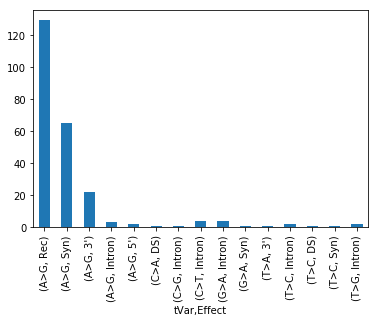

In [342]:
ANNOTATION_DF[(ANNOTATION_DF.Allele==ANNOTATION_DF.Alt_max) & (ANNOTATION_DF.PrmTpt==True) & (ANNOTATION_DF.GeneID=='Dopeav2030876m.g')][['ID','Ref','Allele','Effect','Alt_sum','Alt_max','Alt_counts','tVar','PrmTpt']].groupby('tVar').Effect.value_counts().plot(kind='bar');

In [343]:
OK_edit_sites = ANNOTATION_DF[(ANNOTATION_DF.Allele==ANNOTATION_DF.Alt_max) & (ANNOTATION_DF.PrmTpt==True) & (ANNOTATION_DF.GeneID=='Dopeav2030876m.g') & (ANNOTATION_DF.tVar=='A>G')][['ID','Ref','Allele','Effect','Alt_sum','Alt_max','Alt_counts','tVar','PrmTpt']].ID.to_list()#.groupby('tVar').Effect.value_counts().plot(kind='bar');
import seaborn as sns

sns.clustermap(.loc[Anot_Albertin.loc[idx_Albertin2].ID.to_list()].fillna(-1), col_cluster=True, row_cluster=False, yticklabels=False, figsize=(10,10)); 
plt.show();


['Dpe09:16833660',
 'Dpe09:16833661',
 'Dpe09:16833694',
 'Dpe09:16833695',
 'Dpe09:16833736',
 'Dpe09:16833825',
 'Dpe09:16833848',
 'Dpe09:16833894',
 'Dpe09:16834849',
 'Dpe09:16836279',
 'Dpe09:16836292',
 'Dpe09:16836305',
 'Dpe09:16836312',
 'Dpe09:16836333',
 'Dpe09:16836340',
 'Dpe09:16836405',
 'Dpe09:16842457',
 'Dpe09:16842475',
 'Dpe09:16842478',
 'Dpe09:16842537',
 'Dpe09:16844447',
 'Dpe09:16844452',
 'Dpe09:16844482',
 'Dpe09:16844506',
 'Dpe09:16844509',
 'Dpe09:16846100',
 'Dpe09:16846101',
 'Dpe09:16846109',
 'Dpe09:16846156',
 'Dpe09:16847912',
 'Dpe09:16848667',
 'Dpe09:16848693',
 'Dpe09:16850568',
 'Dpe09:16850638',
 'Dpe09:16850680',
 'Dpe09:16850681',
 'Dpe09:16851484',
 'Dpe09:16853141',
 'Dpe09:16853162',
 'Dpe09:16853184',
 'Dpe09:16853203',
 'Dpe09:16853912',
 'Dpe09:16853928',
 'Dpe09:16853948',
 'Dpe09:16853949',
 'Dpe09:16853956',
 'Dpe09:16854559',
 'Dpe09:16854651',
 'Dpe09:16856382',
 'Dpe09:16856423',
 'Dpe09:16856451',
 'Dpe09:16856460',
 'Dpe09:1685

In [309]:
ANNOTATION_DF[ANNOTATION_DF.Allele!=ANNOTATION_DF.Alt_max][['ID','Ref','Allele','Alt_sum','Alt_max','Alt_counts','tVar']]

,ID,Ref,Allele,Alt_sum,Alt_max,Alt_counts,tVar
107,Dpe09:7373879,A,T,1,G,"[(G, 19), (T, 1)]",A>T
548,Dpe09:8701707,C,G,1,A,"[(A, 150), (G, 1)]",C>G
550,Dpe09:8701707,C,G,1,A,"[(A, 150), (G, 1)]",C>G
552,Dpe09:8701707,C,G,1,A,"[(A, 150), (G, 1)]",C>G
554,Dpe09:8701707,C,G,1,A,"[(A, 150), (G, 1)]",C>G
556,Dpe09:8701707,C,G,1,A,"[(A, 150), (G, 1)]",C>G
755,Dpe09:10089829,T,A,50,G,"[(G, 147), (A, 50)]",T>A
757,Dpe09:10089829,T,A,50,G,"[(G, 147), (A, 50)]",T>A
937,Dpe09:13065343,A,C,1,G,"[(G, 116), (C, 1)]",A>C
939,Dpe09:13065343,A,C,1,G,"[(G, 116), (C, 1)]",A>C


In [292]:
print ANNOTATION_DF.shape
print ANNOTATION_DF[ANNOTATION_DF.Allele==ANNOTATION_DF.Alt_max].shape


(18081, 22)
(17597, 22)


In [295]:
ANNOTATION_DF[ANNOTATION_DF.Allele==ANNOTATION_DF.Alt_max].Alt_sum

0        13
1        27
2         6
3         6
4         8
5        15
6        11
7        12
8        10
9        12
10        8
11       15
12       32
13        6
14       86
15        7
16        6
17        7
18       13
19        6
20       11
21        6
22       17
23       15
24        7
25        7
26       10
27       20
28        7
29        7
         ..
18050     8
18052    41
18053    41
18054     8
18055     8
18056    10
18057    10
18058     6
18059     6
18060     7
18061     7
18062    25
18063    27
18064    10
18065    11
18066     7
18067     9
18068    14
18069     8
18070    13
18071    10
18072    12
18073    12
18074    31
18075    31
18076     8
18077    11
18078    10
18079     8
18080    11
Name: Alt_sum, Length: 17597, dtype: int64

In [218]:
ANNOTATION_DF[(ANNOTATION_DF.tVar=='A>G') & (ANNOTATION_DF.GeneID=='Dopeav2030876m.g') & (ANNOTATION_DF.Effect=='Rec')]#.Effect.value_counts()

,ID,Ref,Allele,Effect,GeneID,FeatureID,Biotype,Rank,GVSc,GVSp,cDNA_pos_len,CDS_pos_len,Prot_pos_len,Distance,tVar,Prot,B62Score
1018,Dpe09:16833695,A,G,Rec,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,1/58,c.28A>G,p.Lys10Glu,37/8377,28/7305,10/2434,,A>G,K>E,1
1020,Dpe09:16833825,A,G,Rec,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,1/58,c.158A>G,p.Lys53Arg,167/8377,158/7305,53/2434,,A>G,K>R,2
1021,Dpe09:16833848,A,G,Rec,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,1/58,c.181A>G,p.Ser61Gly,190/8377,181/7305,61/2434,,A>G,S>G,0
1022,Dpe09:16833894,A,G,Rec,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,1/58,c.227A>G,p.Lys76Arg,236/8377,227/7305,76/2434,,A>G,K>R,2
1024,Dpe09:16834849,A,G,Rec,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,2/58,c.329A>G,p.Lys110Arg,338/8377,329/7305,110/2434,,A>G,K>R,2
1025,Dpe09:16836279,A,G,Rec,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,3/58,c.386A>G,p.Lys129Arg,395/8377,386/7305,129/2434,,A>G,K>R,2
1027,Dpe09:16836305,A,G,Rec,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,3/58,c.412A>G,p.Ile138Val,421/8377,412/7305,138/2434,,A>G,I>V,3
1028,Dpe09:16836312,A,G,Rec,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,3/58,c.419A>G,p.Lys140Arg,428/8377,419/7305,140/2434,,A>G,K>R,2
1029,Dpe09:16836333,A,G,Rec,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,3/58,c.440A>G,p.Lys147Arg,449/8377,440/7305,147/2434,,A>G,K>R,2
1032,Dpe09:16836405,A,G,Rec,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,3/58,c.512A>G,p.Lys171Arg,521/8377,512/7305,171/2434,,A>G,K>R,2


In [237]:
{k: v for k, v in sorted(counts_AD.items(), key=lambda item: item[1])}

{'A': 96, 'T': 7}

In [281]:
counts_AD = {'A': 96, 'T': 7,'G':96,'C':93}
counts_AD_alt_only = dict()
for alt_i in record.ALT: counts_AD_alt_only[str(alt_i)]  = counts_AD[str(alt_i)]
sort_counts = sorted(counts_AD_alt_only.items(), key=lambda x: x[1], reverse=True)
max_alt_count = sort_counts[0][0]

In [273]:
record.ALT

[G, C]

In [259]:
#counts_AD.keys()[counts_AD.values().index(map(str,record.ALT))] 
counts_AD

{'A': 96, 'C': 8, 'G': 96, 'T': 7}

In [ ]:
ANNOTATION_DF[(ANNOTATION_DF.tVar=='A>G') & (ANNOTATION_DF.GeneID=='Dopeav2030876m.g') & (ANNOTATION_DF.Effect=='Rec')][[]]#.Effect.value_counts()

In [396]:

QUALITY_DF = QUALITY_DF.loc[ANNOTATION_DF.ID.drop_duplicates().to_list(), ['DP', 'DP4.1', 'DP4.2', 'DP4.3', 'DP4.4', 'DP_ALT', 'DP_REF', 'MQ', 'MQ0F', 'SGB', 'VDB']]
Ref = Ref['Ref'].loc[ANNOTATION_DF.ID.drop_duplicates().to_list()]
Alt = Alt['Alt'].loc[ANNOTATION_DF.ID.drop_duplicates().to_list()]
    


In [ ]:
def obtain_anotation_for_site(record):
    annotations = dict()
    annotations
    annotation_ids = ['Allele','Effect','Impact','GeneName','GeneID','Feature_type','FeatureID','Biotype','Rank','GVSc','GVSp','cDNA_pos_len','CDS_pos_len','Prot_pos_len','Distance','Warning']
    counter=0
    for i in range(0,len(record.INFO['ANN']),1):
        annotations[i] = dict()
        annotations[i]['ID'] = ':'.join((map(str,[record.CHROM, record.POS])))
        annotations[i]['Ref'] = record.REF
        for j in range(0,len(annotation_ids),1):
            annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]
            annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]
            
    return(annotations)

In [141]:
def obtain_anotation_for_site(record):
    annotations = dict()
    annotations
    annotation_ids = ['Allele','Effect','Impact','GeneName','GeneID','Feature_type','FeatureID','Biotype','Rank','GVSc','GVSp','cDNA_pos_len','CDS_pos_len','Prot_pos_len','Distance','Warning']
    counter=0
    for i in range(0,len(record.ALT),1):
        annotations[i] = dict()
        annotations[i]['ID'] = ':'.join((map(str,[record.CHROM, record.POS])))
        annotations[i]['Ref'] = record.REF
        for j in range(0,len(annotation_ids),1):
            annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]
            annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]
    
    
    return(annotations)

In [163]:



counts_AD = dict()
for k in [record.REF] +record.ALT:
    counts_AD[str(k)] =0

for s in range(0,len(record.samples),1):
    for i in zip([record.REF] +record.ALT,record.samples[s]['AD']):
        counts_AD[str(i[0])] =  counts_AD[str(i[0])] + i[1]

annotations = dict()
annotation_ids = ['Allele','Effect','Impact','GeneName','GeneID','Feature_type','FeatureID','Biotype','Rank','GVSc','GVSp','cDNA_pos_len','CDS_pos_len','Prot_pos_len','Distance','Warning']


counter=0
for i in range(0,len(record.ALT),1):
    annotations[i] = dict()
    annotations[i]['ID'] = ':'.join((map(str,[record.CHROM, record.POS])))
    annotations[i]['Ref'] = record.REF
    for j in range(0,len(annotation_ids),1):
        annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]
        annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]


for j in annotation.keys():
    annotations[j]['Ref_sum']= counts_AD[annotations[j]['Ref']]     ### :NEW]
    annotations[j]['Alt_sum'] = counts_AD[annotations[j]['Allele']] ### :NEW]

annotations

{0: {'Allele': 'C',
  'Alt_sum': 1,
  'Biotype': 'protein_coding',
  'CDS_pos_len': '780/795',
  'Distance': '',
  'Effect': 'synonymous_variant',
  'FeatureID': 'PAC4GC:38658441',
  'Feature_type': 'transcript',
  'GVSc': 'c.780T>G',
  'GVSp': 'p.Pro260Pro',
  'GeneID': 'Dopeav2000027m.g',
  'GeneName': 'Dopeav2000027m.g',
  'ID': 'Dpe01:1161905',
  'Impact': 'LOW',
  'Prot_pos_len': '260/264',
  'Rank': '9/9',
  'Ref': 'A',
  'Ref_sum': 2544,
  'Warning': '',
  'cDNA_pos_len': '1101/3385'},
 1: {'Allele': 'G',
  'Alt_sum': 5,
  'Biotype': 'protein_coding',
  'CDS_pos_len': '780/795',
  'Distance': '',
  'Effect': 'synonymous_variant',
  'FeatureID': 'PAC4GC:38658441',
  'Feature_type': 'transcript',
  'GVSc': 'c.780T>C',
  'GVSp': 'p.Pro260Pro',
  'GeneID': 'Dopeav2000027m.g',
  'GeneName': 'Dopeav2000027m.g',
  'ID': 'Dpe01:1161905',
  'Impact': 'LOW',
  'Prot_pos_len': '260/264',
  'Rank': '9/9',
  'Ref': 'A',
  'Ref_sum': 2544,
  'Warning': '',
  'cDNA_pos_len': '1101/3385'}}

In [202]:
#NEW function:
def obtain_anotation_for_site(record):
    
    counts_AD = dict()
    for k in [record.REF] +record.ALT:
        counts_AD[str(k)] =0
    
    for s in range(0,len(record.samples),1):
        for i in zip([record.REF] +record.ALT,record.samples[s]['AD']):
            counts_AD[str(i[0])] =  counts_AD[str(i[0])] + i[1]
    
    annotations = dict()
    annotation_ids = ['Allele','Effect','Impact','GeneName','GeneID','Feature_type','FeatureID','Biotype','Rank','GVSc','GVSp','cDNA_pos_len','CDS_pos_len','Prot_pos_len','Distance','Warning']
    
    counter=0
    for i in range(0,len(record.ALT),1):
        annotations[i] = dict()
        annotations[i]['ID'] = ':'.join((map(str,[record.CHROM, record.POS])))
        annotations[i]['Ref'] = record.REF
        for j in range(0,len(annotation_ids),1):
            annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]
            annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]
    
    for j in annotations.keys():
        annotations[j]['Ref_sum'] = counts_AD[str(annotations[j]['Ref'])]     
        annotations[j]['Alt_sum'] = counts_AD[str(annotations[j]['Allele'])] 
    
    
    return(annotations)

In [200]:
vcf_file = '/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/Dpe01_Alon_mRNA_snpeff.vcf'

if 'gz' in vcf_file:
    vcf_reader = vcf.Reader(filename=vcf_file)
else:
    vcf_reader = vcf.Reader(open(vcf_file, 'r'))
    
if len(blosum_file)>0:
    Blosum62 = pd.read_csv(blosum_file, sep='\s+', index_col=0).to_dict()
    
counter = 0
annot_counter = 0    
ANNOTATION = dict()
QUALITY=dict()


REF_dp_samples = dict()
ALT_dp_samples = dict()

ANNOTATION_DF = pd.DataFrame()
for record in vcf_reader:
    if (str(record.ALT) == '[None]') ==False : 
        if sum(record.INFO['DP4'][-2:]) > 5 :

            
            site_ID = ':'.join((map(str,[record.CHROM, record.POS])))
  
            QUALITY[site_ID] = other_fields(record)  #OK
            annotation = obtain_anotation_for_site(record)
            
       
            for j in annotation.keys():
 
                ANNOTATION[annot_counter] = annotation[j]
                annot_counter=1+annot_counter
                
            for s in range(0,len(record.samples),1):
                REF_dp_samples[site_ID,s] = record.samples[s]['AD'][0]
                ALT_dp_samples[site_ID,s] = record.samples[s]['AD'][1]

            ### Testing:    
            if record.ALT == ['G','C']:
                break
            counter= counter+1
            
QUALITY_DF = pd.DataFrame.from_dict(QUALITY, orient='index')#[['DP','DP_REF','DP_ALT' ,'DP4.1', 'DP4.2', 'DP4.3', 'DP4.4', 'MQ', 'MQ0F', 'SGB', 'VDB']]

Alt = convert_to_DF(ALT_dp_samples,'Alt')
Ref = convert_to_DF(REF_dp_samples,'Ref')


ANNOTATION_DF = pd.DataFrame.from_dict(ANNOTATION, orient='index')[['ID', 'Ref', 'Allele', 'Effect','GeneID', 'FeatureID', 'Biotype', 'Rank', 'GVSc', 'GVSp', 'cDNA_pos_len', 'CDS_pos_len', 'Prot_pos_len', 'Distance','Ref_sum','Alt_sum']]
ANNOTATION_DF.loc[:,'Effect'] = ANNOTATION_DF.Effect.apply(lambda x: rename_biotypes[x] if x in rename_biotypes.keys() else x)
ANNOTATION_DF.loc[:,'tVar'] = ANNOTATION_DF.GVSc.apply(lambda x: x[-3:])
ANNOTATION_DF['Prot'] = ''
ANNOTATION_DF.loc[~(ANNOTATION_DF.GVSp==''),'GVSp'] = ANNOTATION_DF[~(ANNOTATION_DF.GVSp=='')].GVSp.apply(lambda x: fix_prot_values(x))
ANNOTATION_DF.loc[~(ANNOTATION_DF.GVSp==''),'Prot']=ANNOTATION_DF[~(ANNOTATION_DF.GVSp=='')].GVSp.apply(lambda x: '>'.join((aa_names[x.replace('p.','')[:3]],  aa_names[x.replace('p.','')[-3:]])))
ANNOTATION_DF['B62Score'] = ''
if len(blosum_file)>0:
    ANNOTATION_DF.loc[~(ANNOTATION_DF.GVSp==''),'B62Score']=ANNOTATION_DF[~(ANNOTATION_DF.GVSp=='')].GVSp.apply(lambda x:  int(Blosum62[aa_names[x.replace('p.','')[:3]]][aa_names[x.replace('p.','')[-3:]]]))


In [201]:
ANNOTATION_DF.head(50)#[ANNOTATION_DF.ID=='Dpe01:1161905']

,ID,Ref,Allele,Effect,GeneID,FeatureID,Biotype,Rank,GVSc,GVSp,cDNA_pos_len,CDS_pos_len,Prot_pos_len,Distance,Ref_sum,Alt_sum,tVar,Prot,B62Score
0,Dpe01:95025,A,T,DS,Dopeav2000002m.g,PAC4GC:38660596,protein_coding,,c.*3487T>A,,,,,2526,96,7,T>A,,
1,Dpe01:96182,A,T,DS,Dopeav2000002m.g,PAC4GC:38660596,protein_coding,,c.*2330T>A,,,,,1369,68,10,T>A,,
2,Dpe01:96761,A,T,DS,Dopeav2000002m.g,PAC4GC:38660596,protein_coding,,c.*1751T>A,,,,,790,17,7,T>A,,
3,Dpe01:98072,G,A,3',Dopeav2000002m.g,PAC4GC:38660596,protein_coding,13/13,c.*440C>T,,,,,440,50,36,C>T,,
4,Dpe01:144937,A,G,Syn,Dopeav2000002m.g,PAC4GC:38660596,protein_coding,7/13,c.2169T>C,p.His723His,2983/4829,2169/3054,723/1017,,33,42,T>C,H>H,8
5,Dpe01:1158642,C,T,DS,Dopeav2000027m.g,PAC4GC:38658441,protein_coding,,c.*3248G>A,,,,,979,5,14,G>A,,
6,Dpe01:1160259,T,C,3',Dopeav2000027m.g,PAC4GC:38658441,protein_coding,9/9,c.*1631A>G,,,,,1631,434,11,A>G,,
7,Dpe01:1160264,T,C,3',Dopeav2000027m.g,PAC4GC:38658441,protein_coding,9/9,c.*1626A>G,,,,,1626,178,263,A>G,,
8,Dpe01:1160304,T,C,3',Dopeav2000027m.g,PAC4GC:38658441,protein_coding,9/9,c.*1586A>G,,,,,1586,276,26,A>G,,
9,Dpe01:1160433,T,A,3',Dopeav2000027m.g,PAC4GC:38658441,protein_coding,9/9,c.*1457A>T,,,,,1457,719,1,A>T,,


In [158]:
ANNOTATION_DF[ANNOTATION_DF.ID=='Dpe01:1161905'].sort_values(['Alt_sum'], ascending=False)

,ID,Ref,Allele,Effect,GeneID,FeatureID,Biotype,Rank,GVSc,GVSp,cDNA_pos_len,CDS_pos_len,Prot_pos_len,Distance,Ref_sum,Alt_sum,tVar,Prot,B62Score
73,Dpe01:1161905,A,G,Syn,Dopeav2000027m.g,PAC4GC:38658441,protein_coding,9/9,c.780T>C,p.Pro260Pro,1101/3385,780/795,260/264,,2544,5,T>C,P>P,7
72,Dpe01:1161905,A,C,Syn,Dopeav2000027m.g,PAC4GC:38658441,protein_coding,9/9,c.780T>G,p.Pro260Pro,1101/3385,780/795,260/264,,2544,1,T>G,P>P,7


In [160]:
ANNOTATION_DF.sort_values(['ID','Alt_sum'], ascending=[True,False])

,ID,Ref,Allele,Effect,GeneID,FeatureID,Biotype,Rank,GVSc,GVSp,cDNA_pos_len,CDS_pos_len,Prot_pos_len,Distance,Ref_sum,Alt_sum,tVar,Prot,B62Score
5,Dpe01:1158642,C,T,DS,Dopeav2000027m.g,PAC4GC:38658441,protein_coding,,c.*3248G>A,,,,,979,5,14,G>A,,
6,Dpe01:1160259,T,C,3',Dopeav2000027m.g,PAC4GC:38658441,protein_coding,9/9,c.*1631A>G,,,,,1631,434,11,A>G,,
7,Dpe01:1160264,T,C,3',Dopeav2000027m.g,PAC4GC:38658441,protein_coding,9/9,c.*1626A>G,,,,,1626,178,263,A>G,,
8,Dpe01:1160304,T,C,3',Dopeav2000027m.g,PAC4GC:38658441,protein_coding,9/9,c.*1586A>G,,,,,1586,276,26,A>G,,
10,Dpe01:1160433,T,C,3',Dopeav2000027m.g,PAC4GC:38658441,protein_coding,9/9,c.*1457A>G,,,,,1457,719,6,A>G,,
9,Dpe01:1160433,T,A,3',Dopeav2000027m.g,PAC4GC:38658441,protein_coding,9/9,c.*1457A>T,,,,,1457,719,1,A>T,,
11,Dpe01:1160452,T,C,3',Dopeav2000027m.g,PAC4GC:38658441,protein_coding,9/9,c.*1438A>G,,,,,1438,695,12,A>G,,
12,Dpe01:1160469,T,C,3',Dopeav2000027m.g,PAC4GC:38658441,protein_coding,9/9,c.*1421A>G,,,,,1421,632,26,A>G,,
13,Dpe01:1160476,T,C,3',Dopeav2000027m.g,PAC4GC:38658441,protein_coding,9/9,c.*1414A>G,,,,,1414,582,13,A>G,,
14,Dpe01:1160477,T,C,3',Dopeav2000027m.g,PAC4GC:38658441,protein_coding,9/9,c.*1413A>G,,,,,1413,571,15,A>G,,


In [139]:
for i in range(0,len(record.ALT),1):
    print record.INFO['ANN'][i]

C|synonymous_variant|LOW|Dopeav2000027m.g|Dopeav2000027m.g|transcript|PAC4GC:38658441|protein_coding|9/9|c.780T>G|p.Pro260Pro|1101/3385|780/795|260/264||
G|synonymous_variant|LOW|Dopeav2000027m.g|Dopeav2000027m.g|transcript|PAC4GC:38658441|protein_coding|9/9|c.780T>C|p.Pro260Pro|1101/3385|780/795|260/264||


In [122]:
counts_AD['A']

96

In [133]:
record.POS

1161905

In [ ]:
annotation[j]

In [78]:
#record.ALT# == ['G']

counts_AD = dict()
for k in [record.REF] +record.ALT:
    counts_AD[k] =0

for s in range(0,len(record.samples),1):
    print zip([record.REF] +record.ALT,record.samples[s]['AD'])
    for i in zip([record.REF] +record.ALT,record.samples[s]['AD']):
        counts_AD[i[0]] =  counts_AD[i[0]] + i[1]
        

counts_AD

[('A', 328), (G, 3), (C, 0)]
[('A', 69), (G, 0), (C, 0)]
[('A', 9), (G, 0), (C, 0)]
[('A', 676), (G, 1), (C, 1)]
[('A', 38), (G, 0), (C, 0)]
[('A', 8), (G, 0), (C, 0)]
[('A', 80), (G, 0), (C, 0)]
[('A', 483), (G, 1), (C, 0)]
[('A', 554), (G, 0), (C, 0)]
[('A', 19), (G, 0), (C, 0)]
[('A', 280), (G, 0), (C, 0)]


{G: 5, C: 1, 'A': 2544}

In [83]:
print ANNOTATION[annot_counter-4]
print ANNOTATION[annot_counter-3]
print ANNOTATION[annot_counter-2]
print ANNOTATION[annot_counter-1]

{'Impact': 'LOW', 'Distance': '', 'GeneName': 'Dopeav2000027m.g', 'Feature_type': 'transcript', 'FeatureID': 'PAC4GC:38658444', 'GVSc': 'c.780T>G', 'Prot_pos_len': '260/264', 'Effect': 'synonymous_variant', 'Rank': '8/8', 'Warning': '', 'CDS_pos_len': '780/795', 'Biotype': 'protein_coding', 'Allele': 'C', 'GVSp': 'p.Pro260Pro', 'Ref': 'A', 'ID': 'Dpe01:1161905', 'GeneID': 'Dopeav2000027m.g', 'cDNA_pos_len': '1082/3366'}
{'Impact': 'LOW', 'Distance': '', 'GeneName': 'Dopeav2000027m.g', 'Feature_type': 'transcript', 'FeatureID': 'PAC4GC:38658444', 'GVSc': 'c.780T>C', 'Prot_pos_len': '260/264', 'Effect': 'synonymous_variant', 'Rank': '8/8', 'Warning': '', 'CDS_pos_len': '780/795', 'Biotype': 'protein_coding', 'Allele': 'G', 'GVSp': 'p.Pro260Pro', 'Ref': 'A', 'ID': 'Dpe01:1161905', 'GeneID': 'Dopeav2000027m.g', 'cDNA_pos_len': '1082/3366'}
{'Impact': 'LOW', 'Distance': '', 'GeneName': 'Dopeav2000027m.g', 'Feature_type': 'transcript', 'FeatureID': 'PAC4GC:38658442', 'GVSc': 'c.780T>G', 'Pro

In [101]:
#counts_AD[ANNOTATION[annot_counter-1]['Ref']]
counts_AD[ANNOTATION[annot_counter-1]['Ref']]
counts_AD[ANNOTATION[annot_counter-1]['Allele']]

KeyError: 'G'

In [102]:
counts_AD

{G: 5, C: 1, 'A': 2544}

In [98]:
counts_AD

{G: 5, C: 1, 'A': 2544}

In [75]:
ANNOTATION[annot_counter-1]

{'Allele': 'G',
 'Biotype': 'protein_coding',
 'CDS_pos_len': '780/795',
 'Distance': '',
 'Effect': 'synonymous_variant',
 'FeatureID': 'PAC4GC:38658442',
 'Feature_type': 'transcript',
 'GVSc': 'c.780T>C',
 'GVSp': 'p.Pro260Pro',
 'GeneID': 'Dopeav2000027m.g',
 'GeneName': 'Dopeav2000027m.g',
 'ID': 'Dpe01:1161905',
 'Impact': 'LOW',
 'Prot_pos_len': '260/264',
 'Rank': '8/8',
 'Ref': 'A',
 'Warning': '',
 'cDNA_pos_len': '881/3165'}

In [238]:
#QUALITY_DF.head()

In [397]:
idx_pass_qual = QUALITY_DF[(QUALITY_DF.MQ>30) &  ((QUALITY_DF['DP_ALT']+QUALITY_DF['DP_REF'])>10) & (QUALITY_DF['DP_ALT']>=5)].index.to_list()
print len(idx_pass_qual), QUALITY_DF.shape[0]

ids_ADAR = ANNOTATION_DF[(ANNOTATION_DF.ID.isin(idx_pass_qual)) & (ANNOTATION_DF.GeneID=='Dopeav2030876m.g') &(ANNOTATION_DF.GVSc.str.contains('A>G'))].ID.to_list()
print len(ids_ADAR)

ids_ADAR = ANNOTATION_DF[ (ANNOTATION_DF.GeneID=='Dopeav2030876m.g') &(ANNOTATION_DF.GVSc.str.contains('A>G'))].ID.to_list()
print len(ids_ADAR)

idx_ADAR = ANNOTATION_DF[ANNOTATION_DF.ID.isin(ids_ADAR)].ID.drop_duplicates().index.to_list()
print len(idx_ADAR)


6796 6796
221
221
221


In [398]:
print ANNOTATION_DF.loc[idx_ADAR].Effect.value_counts()
print ANNOTATION_DF.loc[idx_ADAR].groupby('Effect').Prot.value_counts()

Rec          132
Syn           61
3'            22
Intron         3
SJ             2
Stop_gain      1
Name: Effect, dtype: int64
Effect     Prot
3'                 22
Intron              3
Rec        K>R     39
           Q>R     14
           N>S     12
           S>G     12
           I>V      9
           T>A      9
           E>G      7
           N>D      7
           R>G      6
           K>E      5
           M>V      3
           Q>H      2
           Y>C      2
           E>D      1
           I>L      1
           I>M      1
           L>F      1
           N>H      1
SJ                  2
Stop_gain  R>*      1
Syn        E>E     21
           Q>Q     15
           L>L     14
           V>V      4
           K>K      3
           G>G      2
           A>A      1
           S>S      1
Name: Prot, dtype: int64


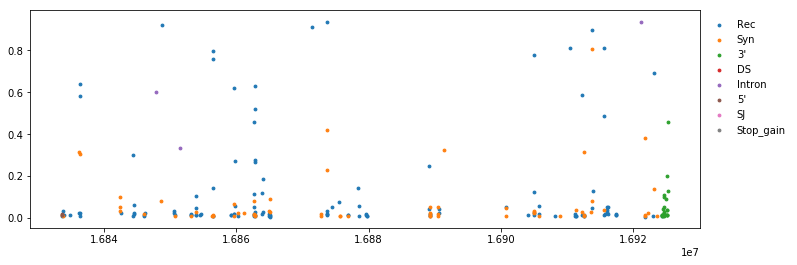

In [404]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
ids_ADAR = ANNOTATION_DF[ (ANNOTATION_DF.GeneID=='Dopeav2030876m.g') &(ANNOTATION_DF.GVSc.str.contains('A>G'))].ID.to_list()
for i in ANNOTATION_DF[ANNOTATION_DF.ID.isin(ids_ADAR)].Effect.value_counts().index.to_list():
    ids_to_plot = ANNOTATION_DF[ (ANNOTATION_DF.Effect==i) &(ANNOTATION_DF.GeneID=='Dopeav2030876m.g') &(ANNOTATION_DF.GVSc.str.contains('A>G'))].ID.to_list()
    position = Alt[0].loc[ids_to_plot].index.to_series().apply(lambda x: int(x.split(':')[1])).to_list()
    edit_freqs = (Alt.loc[ids_to_plot][0]/(Ref.loc[ids_to_plot][0] + Alt.loc[ids_to_plot][0])).to_list()
    plt.scatter(position, edit_freqs, label=i, s=8)
plt.legend(bbox_to_anchor=(1,1), frameon=False)
plt.show()

Series([], Name: 0, dtype: float64)

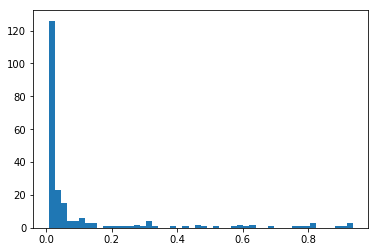

In [425]:
edit_freqs = pd.Series((Alt.loc[ids_ADAR][0]/(Ref.loc[ids_ADAR][0] + Alt.loc[ids_ADAR][0])))
#plt.hist(edit_freqs, bins=50);
((edit_freqs*10).astype(int)).value_counts().sort_index()
plt.hist(edit_freqs, bins=50);
edit_freqs[edit_freqs>20]

In [436]:
edit_freqs[edit_freqs>.32].shape

(26,)

In [435]:
ANNOTATION_DF[ANNOTATION_DF.ID=='Dpe09:16836292']

,ID,Ref,Allele,Effect,GeneID,FeatureID,Biotype,Rank,GVSc,GVSp,cDNA_pos_len,CDS_pos_len,Prot_pos_len,Distance,tVar,Prot,B62Score
3207,Dpe09:16836292,A,G,Syn,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,3/58,c.399A>G,p.Leu133Leu,408/8377,399/7305,133/2434,,A>G,L>L,4
3208,Dpe09:16836292,A,G,DS,Dopeav2030875m.g,PAC4GC:38573198,protein_coding,,c.*13222A>G,,,,,2544,A>G,,


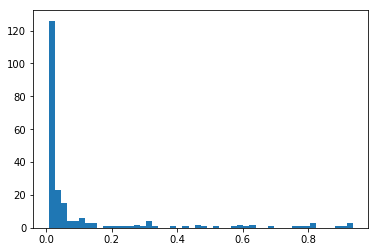

In [407]:
ANNOTATION_DF[ANNOTATION_DF.ID.isin(ids_ADAR)].Effect.value_counts()

# After modifying parameters for mpileup, I was able to call 139 Rec and 65 Syn (without removing the genomic variants yet). These variants 


In [389]:
#ids_ADAR

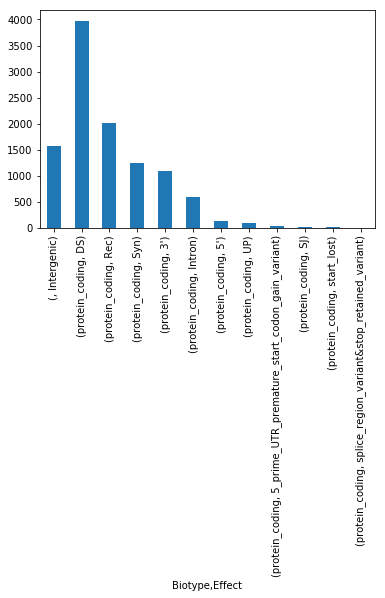

In [386]:
ANNOTATION_DF[ (ANNOTATION_DF.tVar=='A>G') ].groupby('Biotype').Effect.value_counts().plot(kind='bar');

In [385]:
#ANNOTATION_DF.tail()

In [228]:
ANNOTATION_DF.Biotype.value_counts()#[ANNOTATION_DF.Biotype == 'protein_coding']

protein_coding    14636
                   3445
Name: Biotype, dtype: int64

In [323]:
ANNOTATION_DF.loc[3390:3400]#[ANNOTATION_DF.ID=='Dpe09:16913790']

,ID,Ref,Allele,Effect,GeneID,FeatureID,Biotype,Rank,GVSc,GVSp,cDNA_pos_len,CDS_pos_len,Prot_pos_len,Distance,tVar,Prot,B62Score
3390,Dpe09:16912480,A,G,Syn,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,46/58,c.5769A>G,p.Gln1923Gln,5778/8377,5769/7305,1923/2434,,A>G,Q>Q,5
3391,Dpe09:16912523,A,G,Rec,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,46/58,c.5812A>G,p.Thr1938Ala,5821/8377,5812/7305,1938/2434,,A>G,T>A,0
3392,Dpe09:16912552,A,G,Syn,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,46/58,c.5841A>G,p.Leu1947Leu,5850/8377,5841/7305,1947/2434,,A>G,L>L,4
3393,Dpe09:16912559,A,G,Rec,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,46/58,c.5848A>G,p.Ile1950Val,5857/8377,5848/7305,1950/2434,,A>G,I>V,3
3394,Dpe09:16912579,A,G,Syn,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,46/58,c.5868A>G,p.Val1956Val,5877/8377,5868/7305,1956/2434,,A>G,V>V,4
3395,Dpe09:16913592,A,G,Syn,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,47/58,c.5928A>G,p.Leu1976Leu,5937/8377,5928/7305,1976/2434,,A>G,L>L,4
3396,Dpe09:16913776,A,G,Syn,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,48/58,c.5979A>G,p.Leu1993Leu,5988/8377,5979/7305,1993/2434,,A>G,L>L,4
3397,Dpe09:16913790,A,G,Rec,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,48/58,c.5993A>G,p.Lys1998Arg,6002/8377,5993/7305,1998/2434,,A>G,K>R,2
3398,Dpe09:16913794,A,G,Syn,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,48/58,c.5997A>G,p.Glu1999Glu,6006/8377,5997/7305,1999/2434,,A>G,E>E,5
3399,Dpe09:16913807,A,G,Rec,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,48/58,c.6010A>G,p.Ile2004Val,6019/8377,6010/7305,2004/2434,,A>G,I>V,3


In [346]:
Ref_four = pd.read_csv('/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/VCF_parser/Dpe09_Alon_mRNA_snpeff_parsed.Ref.tab', sep='\t', index_col=0)
Ref_four.head()

Alt_four = pd.read_csv('/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/VCF_parser/Dpe09_Alon_mRNA_snpeff_parsed.Alt.tab', sep='\t', index_col=0)
Alt_four.head()

,0,1,2,3
index,,,,
Dpe09:1664890,0,12,0,0
Dpe09:3786575,2,5,2,3
Dpe09:4585635,2,120,10,11
Dpe09:4585675,0,40,2,6
Dpe09:4585909,1,26,0,0


In [380]:
ANNOTATION_DF[(ANNOTATION_DF.index.isin(idx_ADAR)) & (ANNOTATION_DF.Ref=='A') &  (ANNOTATION_DF.Allele=='G') & (ANNOTATION_DF.Biotype=='protein_coding')].Effect.value_counts()

Rec       126
Syn        61
3'         22
Intron      3
SJ          2
Name: Effect, dtype: int64

In [1195]:
ANNOTATION_DF[(ANNOTATION_DF.ID.isin(idx_pass_qual)) & (ANNOTATION_DF.Ref=='A') &  (ANNOTATION_DF.Allele=='G') & (ANNOTATION_DF.Biotype=='protein_coding')].head()

,ID,Ref,Allele,Effect,GeneID,FeatureID,Biotype,Rank,GVSc,GVSp,cDNA_pos_len,CDS_pos_len,Prot_pos_len,Distance,Prot
1,Dpe09:16001701,A,G,Rec,Dopeav2030847m.g,PAC4GC:38573468,protein_coding,45/46,c.6427A>G,p.Asn2143Asp,6427/6627,6427/6627,2143/2208,,N>D
139,Dpe09:16687454,A,G,Rec,Dopeav2030871m.g,PAC4GC:38575474,protein_coding,1/2,c.262A>G,p.Lys88Glu,393/869,262/738,88/245,,K>E
140,Dpe09:16687454,A,G,DS,Dopeav2030870m.g,PAC4GC:38575530,protein_coding,,c.*5053A>G,,,,,4618,
175,Dpe09:16690893,A,G,DS,Dopeav2030871m.g,PAC4GC:38575474,protein_coding,,c.*291A>G,,,,,291,
177,Dpe09:16690894,A,G,DS,Dopeav2030871m.g,PAC4GC:38575474,protein_coding,,c.*292A>G,,,,,292,


In [1196]:
ANNOTATION_DF[ANNOTATION_DF.ID=='Dpe09:16913790']

,ID,Ref,Allele,Effect,GeneID,FeatureID,Biotype,Rank,GVSc,GVSp,cDNA_pos_len,CDS_pos_len,Prot_pos_len,Distance,Prot
412,Dpe09:16913790,A,G,Rec,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,48/58,c.5993A>G,p.Lys1998Arg,6002/8377,5993/7305,1998/2434,,K>R
620,Dpe09:16913790,A,G,Rec,Dopeav2030876m.g,PAC4GC:38575923,protein_coding,48/58,c.5993A>G,p.Lys1998Arg,6002/8377,5993/7305,1998/2434,,K>R


### Do not remove. This is the code use to produce outputs:

#### ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting.py

In [ ]:
# SNPeff parser to identify and annotate variants from RNA-seq.
# June 16, 2021 - Sofia Medina 
# Rokhsar lab - UC Berkeley
# To run: 

### samtools mpileup -A -Q 35 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf /projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta ../editPaper.GFLr_Dpe09_sorted.bam -r Dpe09:16717516-17000000  |bcftools call -m -A --skip-variants indels | bcftools filter -g3 -i 'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5' >Dpe09_test.vcf && java -jar ../../snpEff/snpEff.jar eff Squid_v2 Dpe09_test.vcf >Dpe09_test_snpeff.vcf
### module load python/2.7-anaconda-4.4 && source activate Cori_new && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting.py -v /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/Dpe09_test_snpeff.vcf 
### emacs ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting.py
### It takes 5 seconds!

import argparse, os
import vcf
import pandas as pd
import time
import sys
import numpy as np

rename_biotypes = {'missense_variant':'Rec', 'synonymous_variant':'Syn',
 '3_prime_UTR_variant':"3'", 'intron_variant':'Intron', 
 'downstream_gene_variant':'DS', 'missense_variant&splice_region_variant':'Rec', 
 'splice_region_variant&synonymous_variant':'Syn', 'upstream_gene_variant':'UP', 
 'splice_region_variant':'SJ', '5_prime_UTR_variant':"5'", 'stop_lost':'Stop_loss', 
 'stop_gained':'Stop_gain', 'splice_acceptor_variant&intron_variant':'SJ', 
 'splice_region_variant':'SJ', 'splice_region_variant&intron_variant':'SJ',
 'stop_gained&splice_region_variant':'Stop_gain',
 'intergenic_region':'Intergenic', 'stop_retained':'Syn','initiator_codon_variant':'Rec', 
 'splice_donor_variant&intron_variant':'SJ',
 'splice_region_variant&stop_retained_variant':'Syn', 'start_lost&splice_region_variant' :'SJ',
 'start_lost':'Rec','stop_lost&splice_region_variant':'Rec',
 'stop_retained_variant':'Syn','5_prime_UTR_premature_start_codon_gain_variant':"5'", 'Stop_loss':'Rec'}

aa_names = {'Ala':'A','Arg':'R','Asn':'N','Asp':'D','Cys':'C',
            'Glu':'E','Gln':'Q','Gly':'G','His':'H','Ile':'I',
            'Leu':'L','Lys':'K','Met':'M','Phe':'F','Pro':'P',
            'Ser':'S','Thr':'T','Trp':'W','Tyr':'Y','Val':'V',
            'Ter':'*','Nan':'X'}

def parse_args():
    parser = argparse.ArgumentParser(description='VCF parser for RNA transcript variants')
    parser.add_argument("-o", "--outputDir", metavar='STR', help='Directory where output files will be written', type=str, default='./VCF_parser/')
    parser.add_argument("-b", "--Blosum62", metavar='STR', help='Path to blosum62 matrix', type=str, default='/global/homes/s/sofiamr/IpythonNotebooks/SquidAnalysis/February_2020/blosum62.mtx')
    parser.add_argument('-m', '--moduleLoad', metavar='STR', help='Environment requirements', type=str, default="module load python/2.7-anaconda-4.4 && source activate Cori_new && ")
    parser.add_argument("-V", "--version", action='version', version='%(prog)s 2.0')
    required = parser.add_argument_group('required arguments')
    required.add_argument('-v', "--vcf", help="Path to snpEff output file", type=str, default ='/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/Dpe09_test_snpeff.vcf')
    args = parser.parse_args()
    
    if (args.vcf.endswith('.vcf') | args.vcf.endswith('.vcf.gz')):
        if os.path.exists(args.vcf):
            print "Input vcf file:", args.vcf
    else:
        print "Please provide a VCF file"
        sys.exit(2) 
    return(args)

def main():
    args = parse_args()
    vcf_file =  args.vcf  
    blosum_file =  args.Blosum62  
    output_dir = args.outputDir.replace('//','/')
    
    print_time('Program running')
    ensure_dir(output_dir)
    parse_snpeff(vcf_file, output_dir, blosum_file)
    print_time('Done!')
    return()

def parse_snpeff(vcf_file, output_dir, blosum_file):
    if 'gz' in vcf_file:
        vcf_reader = vcf.Reader(filename=vcf_file)
    else:
        vcf_reader = vcf.Reader(open(vcf_file, 'r'))
        
    if len(blosum_file)>0:
        Blosum62 = pd.read_csv(blosum_file, sep='\s+', index_col=0).to_dict()
        
    counter = 0
    annot_counter = 0    
    ANNOTATION = dict()
    QUALITY=dict()
    
    
    REF_dp_samples = dict()
    ALT_dp_samples = dict()
    
    ANNOTATION_DF = pd.DataFrame()
    for record in vcf_reader:
        if (str(record.ALT) == '[None]') ==False : 
            if sum(record.INFO['DP4'][-2:]) > 5 :
                counter= counter+1
                site_ID = ':'.join((map(str,[record.CHROM, record.POS])))
      
                QUALITY[site_ID] = other_fields(record)  #OK
                annotation = obtain_anotation_for_site(record)
                for j in annotation.keys():
                    ANNOTATION[annot_counter] = annotation[j]
                    annot_counter=1+annot_counter
                    
                for s in range(0,len(record.samples),1):
                    REF_dp_samples[site_ID,s] = record.samples[s]['AD'][0]
                    ALT_dp_samples[site_ID,s] = record.samples[s]['AD'][1]
    
                    
    QUALITY_DF = pd.DataFrame.from_dict(QUALITY, orient='index')#[['DP','DP_REF','DP_ALT' ,'DP4.1', 'DP4.2', 'DP4.3', 'DP4.4', 'MQ', 'MQ0F', 'SGB', 'VDB']]
    
    Alt = convert_to_DF(ALT_dp_samples,'Alt')
    Ref = convert_to_DF(REF_dp_samples,'Ref')
    
    
    ANNOTATION_DF = pd.DataFrame.from_dict(ANNOTATION, orient='index')[['ID', 'Ref', 'Allele', 'Effect','GeneID', 'FeatureID', 'Biotype', 'Rank', 'GVSc', 'GVSp', 'cDNA_pos_len', 'CDS_pos_len', 'Prot_pos_len', 'Distance']]
    ANNOTATION_DF.loc[:,'Effect'] = ANNOTATION_DF.Effect.apply(lambda x: rename_biotypes[x] if x in rename_biotypes.keys() else x)
    ANNOTATION_DF.loc[:,'tVar'] = ANNOTATION_DF.GVSc.apply(lambda x: x[-3:])
    ANNOTATION_DF['Prot'] = ''
    ANNOTATION_DF.loc[~(ANNOTATION_DF.GVSp==''),'GVSp'] = ANNOTATION_DF[~(ANNOTATION_DF.GVSp=='')].GVSp.apply(lambda x: fix_prot_values(x))
    ANNOTATION_DF.loc[~(ANNOTATION_DF.GVSp==''),'Prot']=ANNOTATION_DF[~(ANNOTATION_DF.GVSp=='')].GVSp.apply(lambda x: '>'.join((aa_names[x.replace('p.','')[:3]],  aa_names[x.replace('p.','')[-3:]])))
    ANNOTATION_DF['B62Score'] = ''
    if len(blosum_file)>0:
        ANNOTATION_DF.loc[~(ANNOTATION_DF.GVSp==''),'B62Score']=ANNOTATION_DF[~(ANNOTATION_DF.GVSp=='')].GVSp.apply(lambda x:  int(Blosum62[aa_names[x.replace('p.','')[:3]]][aa_names[x.replace('p.','')[-3:]]]))
    
    
    #### Write outputs
    out_files = write_outputs(vcf_file, output_dir)
    
    ANNOTATION_DF.to_csv(out_files['Annotation'], sep='\t')    
    QUALITY_DF.loc[ANNOTATION_DF.ID.drop_duplicates().to_list(), ['DP', 'DP4.1', 'DP4.2', 'DP4.3', 'DP4.4', 'DP_ALT', 'DP_REF', 'MQ', 'MQ0F', 'SGB', 'VDB']].to_csv(out_files['Quality'], sep='\t')
    Ref['Ref'].loc[ANNOTATION_DF.ID.drop_duplicates().to_list()].to_csv(out_files['Ref_calls'], sep='\t')
    Alt['Alt'].loc[ANNOTATION_DF.ID.drop_duplicates().to_list()].to_csv(out_files['Alt_calls'], sep='\t')

    print 'Saved files:'
    for i in out_files.keys():
        print i,'as:\t', out_files[i]
        
    return(QUALITY_DF, ANNOTATION_DF, Ref, Alt)


def other_fields(record):
    site_data = dict()
    site_data = dict()
    # All_fields = ['MQB', 'BQB', 'RPB', 'VDB', 'MQSB', 'MQ0F', 'SGB','ANN', 'DP4'] 
    fields_of_interest_float = [ 'VDB',  'MQ0F', 'SGB']
    fields_of_interest_int = ['DP','MQ'] 

    for i in fields_of_interest_float+fields_of_interest_int:
        if i in fields_of_interest_int:
            #site_data[i] = int(record.INFO[i][0])
            site_data[i] = int(record.INFO[i])
        else:
            #site_data[i] = float(record.INFO[i][0])
            site_data[i] = float(record.INFO[i])
    
    for i in range(0,len(record.INFO['DP4']),1):
        site_data['.'.join(('DP4',str(i+1)))] = int(record.INFO['DP4'][i])
    site_data['DP_REF'] = int(record.INFO['DP4'][0]) + int(record.INFO['DP4'][1])
    site_data['DP_ALT'] = int(record.INFO['DP4'][2]) + int(record.INFO['DP4'][3])
    return(site_data)


def obtain_anotation_for_site(record):
    annotations = dict()
    annotations
    annotation_ids = ['Allele','Effect','Impact','GeneName','GeneID','Feature_type','FeatureID','Biotype','Rank','GVSc','GVSp','cDNA_pos_len','CDS_pos_len','Prot_pos_len','Distance','Warning']
    counter=0
    for i in range(0,len(record.INFO['ANN']),1):
        annotations[i] = dict()
        annotations[i]['ID'] = ':'.join((map(str,[record.CHROM, record.POS])))
        annotations[i]['Ref'] = record.REF
        for j in range(0,len(annotation_ids),1):
            annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]
            annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]
    return(annotations)

def convert_to_DF(dict_depth,label):
    Tst = pd.DataFrame.from_dict(dict_depth, orient='index')
    Tst = Tst.reset_index()
    Tst = Tst.rename(columns={0:label})
    Tst['sample'] = Tst['index'].apply(lambda x: x[1])
    Tst['index'] = Tst['index'].apply(lambda x: x[0])
    Tst = Tst.set_index('index')
    Tst = Tst.pivot(columns='sample')
    return(Tst)

def add_blosum62_value(Prot_pair_aa):
    Ref_aa = aa_names[Prot_pair_aa[:3]]
    Alt_aa = aa_names[Prot_pair_aa[-3:]]
    return(int(Blosum62[Ref_aa][Alt_aa]))

def fix_prot_values(Prot_pair_aa):
    Prot_pair_aa = Prot_pair_aa.replace('ext*?','')
    Prot_pair_aa = Prot_pair_aa.replace('?','Nan')
    Prot_pair_aa = Prot_pair_aa.replace('*','Ter')
    return(Prot_pair_aa)

def write_outputs(vcf_file, output_dir):
    out_files = dict() 
    vcf_name = vcf_file.split('/')[-1].replace('.gz','')
    out_files['Annotation'] = vcf_name.replace('.vcf','_parsed.Ann.tab')
    out_files['Ref_calls'] = vcf_name.replace('.vcf','_parsed.Ref.tab')
    out_files['Alt_calls'] = vcf_name.replace('.vcf','_parsed.Alt.tab')
    out_files['Quality'] = vcf_name.replace('.vcf','_parsed.Qual.tab')
    
    for i in out_files.keys():
        out_files[i]=''.join((output_dir,out_files[i]))
    return(out_files)

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        print "made new dir: ", file_path
    return()

def print_time(extra_text=''):
    t = time.localtime()
    print time.strftime("%D - %H:%M:%S", t), extra_text

    
if __name__=='__main__':
    main()


### Modification on June 23rd

In [ ]:
# SNPeff parser to identify and annotate variants from RNA-seq.
# June 23, 2021 - Sofia Medina 
# Rokhsar lab - UC Berkeley
# To run: 

### samtools mpileup -A -Q 35 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf /projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta ../editPaper.GFLr_Dpe09_sorted.bam -r Dpe09:16717516-17000000  |bcftools call -m -A --skip-variants indels | bcftools filter -g3 -i 'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5' >Dpe09_test.vcf && java -jar ../../snpEff/snpEff.jar eff Squid_v2 Dpe09_test.vcf >Dpe09_test_snpeff.vcf
### module load python/2.7-anaconda-4.4 && source activate Cori_new && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting.py -v /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/Dpe09_test_snpeff.vcf 
### emacs ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting.py
### It takes 5 seconds!

import argparse, os
import vcf
import pandas as pd
import time
import sys
import numpy as np

rename_biotypes = {'missense_variant':'Rec', 'synonymous_variant':'Syn',
 '3_prime_UTR_variant':"3'", 'intron_variant':'Intron', 
 'downstream_gene_variant':'DS', 'missense_variant&splice_region_variant':'Rec', 
 'splice_region_variant&synonymous_variant':'Syn', 'upstream_gene_variant':'UP', 
 'splice_region_variant':'SJ', '5_prime_UTR_variant':"5'", 'stop_lost':'Stop_loss', 
 'stop_gained':'Stop_gain', 'splice_acceptor_variant&intron_variant':'SJ', 
 'splice_region_variant':'SJ', 'splice_region_variant&intron_variant':'SJ',
 'stop_gained&splice_region_variant':'Stop_gain',
 'intergenic_region':'Intergenic', 'stop_retained':'Syn','initiator_codon_variant':'Rec', 
 'splice_donor_variant&intron_variant':'SJ',
 'splice_region_variant&stop_retained_variant':'Syn', 'start_lost&splice_region_variant' :'SJ',
 'start_lost':'Rec','stop_lost&splice_region_variant':'Rec',
 'stop_retained_variant':'Syn','5_prime_UTR_premature_start_codon_gain_variant':"5'", 'Stop_loss':'Rec'}

aa_names = {'Ala':'A','Arg':'R','Asn':'N','Asp':'D','Cys':'C',
            'Glu':'E','Gln':'Q','Gly':'G','His':'H','Ile':'I',
            'Leu':'L','Lys':'K','Met':'M','Phe':'F','Pro':'P',
            'Ser':'S','Thr':'T','Trp':'W','Tyr':'Y','Val':'V',
            'Ter':'*','Nan':'X'}

def parse_args():
    parser = argparse.ArgumentParser(description='VCF parser for RNA transcript variants')
    parser.add_argument("-o", "--outputDir", metavar='STR', help='Directory where output files will be written', type=str, default='./VCF_parser/')
    parser.add_argument("-b", "--Blosum62", metavar='STR', help='Path to blosum62 matrix', type=str, default='/global/homes/s/sofiamr/IpythonNotebooks/SquidAnalysis/February_2020/blosum62.mtx')
    parser.add_argument('-m', '--moduleLoad', metavar='STR', help='Environment requirements', type=str, default="module load python/2.7-anaconda-4.4 && source activate Cori_new && ")
    parser.add_argument("-V", "--version", action='version', version='%(prog)s 2.0')
    required = parser.add_argument_group('required arguments')
    required.add_argument('-v', "--vcf", help="Path to snpEff output file", type=str, default ='/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/Dpe09_test_snpeff.vcf')
    args = parser.parse_args()
    
    if (args.vcf.endswith('.vcf') | args.vcf.endswith('.vcf.gz')):
        if os.path.exists(args.vcf):
            print "Input vcf file:", args.vcf
    else:
        print "Please provide a VCF file"
        sys.exit(2) 
    return(args)

def main():
    args = parse_args()
    vcf_file =  args.vcf  
    blosum_file =  args.Blosum62  
    output_dir = args.outputDir.replace('//','/')
    
    print_time('Program running')
    ensure_dir(output_dir)
    parse_snpeff(vcf_file, output_dir, blosum_file)
    print_time('Done!')
    return()

def parse_snpeff(vcf_file, output_dir, blosum_file):
    if 'gz' in vcf_file:
        vcf_reader = vcf.Reader(filename=vcf_file)
    else:
        vcf_reader = vcf.Reader(open(vcf_file, 'r'))
        
    if len(blosum_file)>0:
        Blosum62 = pd.read_csv(blosum_file, sep='\s+', index_col=0).to_dict()
        
    counter = 0
    annot_counter = 0    
    ANNOTATION = dict()
    QUALITY=dict()
    
    
    REF_dp_samples = dict()
    ALT_dp_samples = dict()
    
    ANNOTATION_DF = pd.DataFrame()
    for record in vcf_reader:
        if (str(record.ALT) == '[None]') ==False : 
            if sum(record.INFO['DP4'][-2:]) > 5 :
                counter= counter+1
                site_ID = ':'.join((map(str,[record.CHROM, record.POS])))
      
                QUALITY[site_ID] = other_fields(record)  #OK
                annotation = obtain_anotation_for_site(record)
                for j in annotation.keys():
                    ANNOTATION[annot_counter] = annotation[j]
                    annot_counter=1+annot_counter
                    
                for s in range(0,len(record.samples),1):
                    REF_dp_samples[site_ID,s] = record.samples[s]['AD'][0]
                    ALT_dp_samples[site_ID,s] = record.samples[s]['AD'][1]
    
                    
    QUALITY_DF = pd.DataFrame.from_dict(QUALITY, orient='index')#[['DP','DP_REF','DP_ALT' ,'DP4.1', 'DP4.2', 'DP4.3', 'DP4.4', 'MQ', 'MQ0F', 'SGB', 'VDB']]
    
    Alt = convert_to_DF(ALT_dp_samples,'Alt')
    Ref = convert_to_DF(REF_dp_samples,'Ref')
    
    
    ANNOTATION_DF = pd.DataFrame.from_dict(ANNOTATION, orient='index')[['ID', 'Ref', 'Allele', 'Effect','GeneID', 'FeatureID', 'Biotype', 'Rank', 'GVSc', 'GVSp', 'cDNA_pos_len', 'CDS_pos_len', 'Prot_pos_len','Impact', 'Distance','Ref_sum','Alt_sum']]
    ANNOTATION_DF.loc[:,'Effect'] = ANNOTATION_DF.Effect.apply(lambda x: rename_biotypes[x] if x in rename_biotypes.keys() else x)
    ANNOTATION_DF.loc[:,'tVar'] = ANNOTATION_DF.GVSc.apply(lambda x: x[-3:])
    ANNOTATION_DF['Prot'] = ''
    ANNOTATION_DF.loc[~(ANNOTATION_DF.GVSp==''),'GVSp'] = ANNOTATION_DF[~(ANNOTATION_DF.GVSp=='')].GVSp.apply(lambda x: fix_prot_values(x))
    ANNOTATION_DF.loc[~(ANNOTATION_DF.GVSp==''),'Prot']=ANNOTATION_DF[~(ANNOTATION_DF.GVSp=='')].GVSp.apply(lambda x: '>'.join((aa_names[x.replace('p.','')[:3]],  aa_names[x.replace('p.','')[-3:]])))
    ANNOTATION_DF['Prot_pos'] = ''
    ANNOTATION_DF.loc[~(ANNOTATION_DF.Prot_pos_len==''),'Prot_pos'] = ANNOTATION_DF[~(ANNOTATION_DF.Prot_pos_len=='')]['Prot_pos_len'].apply(lambda x: int(x.split('/')[0]))
    ANNOTATION_DF['B62Score'] = ''
    if len(blosum_file)>0:
        ANNOTATION_DF.loc[~(ANNOTATION_DF.GVSp==''),'B62Score']=ANNOTATION_DF[~(ANNOTATION_DF.GVSp=='')].GVSp.apply(lambda x:  int(Blosum62[aa_names[x.replace('p.','')[:3]]][aa_names[x.replace('p.','')[-3:]]]))

    #### Write outputs
    out_files = write_outputs(vcf_file, output_dir)
    
    ANNOTATION_DF.to_csv(out_files['Annotation'], sep='\t')    
    QUALITY_DF.loc[ANNOTATION_DF.ID.drop_duplicates().to_list(), ['DP', 'DP4.1', 'DP4.2', 'DP4.3', 'DP4.4', 'DP_ALT', 'DP_REF', 'MQ', 'MQ0F', 'SGB', 'VDB']].to_csv(out_files['Quality'], sep='\t')
    Ref['Ref'].loc[ANNOTATION_DF.ID.drop_duplicates().to_list()].to_csv(out_files['Ref_calls'], sep='\t')
    Alt['Alt'].loc[ANNOTATION_DF.ID.drop_duplicates().to_list()].to_csv(out_files['Alt_calls'], sep='\t')

    print 'Saved files:'
    for i in out_files.keys():
        print i,'as:\t', out_files[i]
        
    return(QUALITY_DF, ANNOTATION_DF, Ref, Alt)


def other_fields(record):
    site_data = dict()
    site_data = dict()
    # All_fields = ['MQB', 'BQB', 'RPB', 'VDB', 'MQSB', 'MQ0F', 'SGB','ANN', 'DP4'] 
    fields_of_interest_float = [ 'VDB',  'MQ0F', 'SGB']
    fields_of_interest_int = ['DP','MQ'] 

    for i in fields_of_interest_float+fields_of_interest_int:
        if i in fields_of_interest_int:
            #site_data[i] = int(record.INFO[i][0])
            site_data[i] = int(record.INFO[i])
        else:
            #site_data[i] = float(record.INFO[i][0])
            site_data[i] = float(record.INFO[i])
    
    for i in range(0,len(record.INFO['DP4']),1):
        site_data['.'.join(('DP4',str(i+1)))] = int(record.INFO['DP4'][i])
    site_data['DP_REF'] = int(record.INFO['DP4'][0]) + int(record.INFO['DP4'][1])
    site_data['DP_ALT'] = int(record.INFO['DP4'][2]) + int(record.INFO['DP4'][3])
    return(site_data)


def obtain_anotation_for_site(record):
    
    counts_AD = dict()
    for k in [record.REF] +record.ALT:
        counts_AD[str(k)] =0
    
    for s in range(0,len(record.samples),1):
        for i in zip([record.REF] +record.ALT,record.samples[s]['AD']):
            counts_AD[str(i[0])] =  counts_AD[str(i[0])] + i[1]
    
    annotations = dict()
    annotation_ids = ['Allele','Effect','Impact','GeneName','GeneID','Feature_type','FeatureID','Biotype','Rank','GVSc','GVSp','cDNA_pos_len','CDS_pos_len','Prot_pos_len','Distance','Warning']
    
    counter=0
    for i in range(0,len(record.ALT),1):
        annotations[i] = dict()
        annotations[i]['ID'] = ':'.join((map(str,[record.CHROM, record.POS])))
        annotations[i]['Ref'] = record.REF
        for j in range(0,len(annotation_ids),1):
            annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]
            annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]
    
    for j in annotations.keys():
        annotations[j]['Ref_sum'] = counts_AD[str(annotations[j]['Ref'])]     
        annotations[j]['Alt_sum'] = counts_AD[str(annotations[j]['Allele'])] 
    
    
    return(annotations)

def convert_to_DF(dict_depth,label):
    Tst = pd.DataFrame.from_dict(dict_depth, orient='index')
    Tst = Tst.reset_index()
    Tst = Tst.rename(columns={0:label})
    Tst['sample'] = Tst['index'].apply(lambda x: x[1])
    Tst['index'] = Tst['index'].apply(lambda x: x[0])
    Tst = Tst.set_index('index')
    Tst = Tst.pivot(columns='sample')
    return(Tst)

def add_blosum62_value(Prot_pair_aa):
    Ref_aa = aa_names[Prot_pair_aa[:3]]
    Alt_aa = aa_names[Prot_pair_aa[-3:]]
    return(int(Blosum62[Ref_aa][Alt_aa]))

def fix_prot_values(Prot_pair_aa):
    Prot_pair_aa = Prot_pair_aa.replace('ext*?','')
    Prot_pair_aa = Prot_pair_aa.replace('?','Nan')
    Prot_pair_aa = Prot_pair_aa.replace('*','Ter')
    return(Prot_pair_aa)

def write_outputs(vcf_file, output_dir):
    out_files = dict() 
    vcf_name = vcf_file.split('/')[-1].replace('.gz','')
    out_files['Annotation'] = vcf_name.replace('.vcf','_parsed.Ann.tab')
    out_files['Ref_calls'] = vcf_name.replace('.vcf','_parsed.Ref.tab')
    out_files['Alt_calls'] = vcf_name.replace('.vcf','_parsed.Alt.tab')
    out_files['Quality'] = vcf_name.replace('.vcf','_parsed.Qual.tab')
    
    for i in out_files.keys():
        out_files[i]=''.join((output_dir,out_files[i]))
    return(out_files)

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        print "made new dir: ", file_path
    return()

def print_time(extra_text=''):
    t = time.localtime()
    print time.strftime("%D - %H:%M:%S", t), extra_text

    
if __name__=='__main__':
    main()


In [ ]:
# SNPeff parser to identify and annotate variants from RNA-seq.
# June 23, 2021 - Sofia Medina 
# Rokhsar lab - UC Berkeley
# To run: 

### samtools mpileup -A -Q 35 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf /projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta ../editPaper.GFLr_Dpe09_sorted.bam -r Dpe09:16717516-17000000  |bcftools call -m -A --skip-variants indels | bcftools filter -g3 -i 'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5' >Dpe09_test.vcf && java -jar ../../snpEff/snpEff.jar eff Squid_v2 Dpe09_test.vcf >Dpe09_test_snpeff.vcf
### module load python/2.7-anaconda-4.4 && source activate Cori_new && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_v3.py -v /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/Dpe09_test_snpeff.vcf 
### emacs ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_v3.py
### It takes 5 seconds!

import argparse, os
import vcf
import pandas as pd
import time
import sys
import numpy as np

rename_biotypes = {'missense_variant':'Rec', 'synonymous_variant':'Syn',
 '3_prime_UTR_variant':"3'", 'intron_variant':'Intron', 
 'downstream_gene_variant':'DS', 'missense_variant&splice_region_variant':'Rec', 
 'splice_region_variant&synonymous_variant':'Syn', 'upstream_gene_variant':'UP', 
 'splice_region_variant':'SJ', '5_prime_UTR_variant':"5'", 'stop_lost':'Stop_loss', 
 'stop_gained':'Stop_gain', 'splice_acceptor_variant&intron_variant':'SJ', 
 'splice_region_variant':'SJ', 'splice_region_variant&intron_variant':'SJ',
 'stop_gained&splice_region_variant':'Stop_gain',
 'intergenic_region':'Intergenic', 'stop_retained':'Syn','initiator_codon_variant':'Rec', 
 'splice_donor_variant&intron_variant':'SJ',
 'splice_region_variant&stop_retained_variant':'Syn', 'start_lost&splice_region_variant' :'SJ',
 'start_lost':'Rec','stop_lost&splice_region_variant':'Rec',
 'stop_retained_variant':'Syn','5_prime_UTR_premature_start_codon_gain_variant':"5'", 'Stop_loss':'Rec'}

aa_names = {'Ala':'A','Arg':'R','Asn':'N','Asp':'D','Cys':'C',
            'Glu':'E','Gln':'Q','Gly':'G','His':'H','Ile':'I',
            'Leu':'L','Lys':'K','Met':'M','Phe':'F','Pro':'P',
            'Ser':'S','Thr':'T','Trp':'W','Tyr':'Y','Val':'V',
            'Ter':'*','Nan':'X'}

def parse_args():
    parser = argparse.ArgumentParser(description='VCF parser for RNA transcript variants')
    parser.add_argument("-o", "--outputDir", metavar='STR', help='Directory where output files will be written', type=str, default='./VCF_parser/')
    parser.add_argument("-b", "--Blosum62", metavar='STR', help='Path to blosum62 matrix', type=str, default='/global/homes/s/sofiamr/IpythonNotebooks/SquidAnalysis/February_2020/blosum62.mtx')
    parser.add_argument('-m', '--moduleLoad', metavar='STR', help='Environment requirements', type=str, default="module load python/2.7-anaconda-4.4 && source activate Cori_new && ")
    parser.add_argument("-V", "--version", action='version', version='%(prog)s 2.0')
    required = parser.add_argument_group('required arguments')
    required.add_argument('-v', "--vcf", help="Path to snpEff output file", type=str, default ='/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/Dpe09_test_snpeff.vcf')
    args = parser.parse_args()
    
    if (args.vcf.endswith('.vcf') | args.vcf.endswith('.vcf.gz')):
        if os.path.exists(args.vcf):
            print "Input vcf file:", args.vcf
    else:
        print "Please provide a VCF file"
        sys.exit(2) 
    return(args)

def main():
    args = parse_args()
    vcf_file =  args.vcf  
    blosum_file =  args.Blosum62  
    output_dir = args.outputDir.replace('//','/')
    
    print_time('Program running')
    ensure_dir(output_dir)
    parse_snpeff(vcf_file, output_dir, blosum_file)
    print_time('Done!')
    return()

def parse_snpeff(vcf_file, output_dir, blosum_file):
    if 'gz' in vcf_file:
        vcf_reader = vcf.Reader(filename=vcf_file)
    else:
        vcf_reader = vcf.Reader(open(vcf_file, 'r'))
        
    if len(blosum_file)>0:
        Blosum62 = pd.read_csv(blosum_file, sep='\s+', index_col=0).to_dict()
        
    counter = 0
    annot_counter = 0    
    ANNOTATION = dict()
    QUALITY=dict()
    
    
    REF_dp_samples = dict()
    ALT_dp_samples = dict()
    
    ANNOTATION_DF = pd.DataFrame()
    for record in vcf_reader:
        if (str(record.ALT) == '[None]') ==False : 
            if sum(record.INFO['DP4'][-2:]) > 5 :
                counter= counter+1
                site_ID = ':'.join((map(str,[record.CHROM, record.POS])))
      
                QUALITY[site_ID] = other_fields(record)  #OK
                annotation = obtain_anotation_for_site(record)
                for j in annotation.keys():
                    ANNOTATION[annot_counter] = annotation[j]
                    annot_counter=1+annot_counter
                    
                for s in range(0,len(record.samples),1):
                    REF_dp_samples[site_ID,s] = record.samples[s]['AD'][0]
                    ALT_dp_samples[site_ID,s] = record.samples[s]['AD'][1]
    
                    
    QUALITY_DF = pd.DataFrame.from_dict(QUALITY, orient='index')#[['DP','DP_REF','DP_ALT' ,'DP4.1', 'DP4.2', 'DP4.3', 'DP4.4', 'MQ', 'MQ0F', 'SGB', 'VDB']]
    
    Alt = convert_to_DF(ALT_dp_samples,'Alt')
    Ref = convert_to_DF(REF_dp_samples,'Ref')
    
    
    ANNOTATION_DF = pd.DataFrame.from_dict(ANNOTATION, orient='index')[['ID', 'Ref', 'Allele', 'Effect','GeneID', 'FeatureID', 'Biotype', 'Rank', 'GVSc', 'GVSp', 'cDNA_pos_len', 'CDS_pos_len', 'Prot_pos_len','Impact', 'Distance','Ref_sum','Alt_sum','Alt_max','Alt_counts']]
    ANNOTATION_DF.loc[:,'Effect'] = ANNOTATION_DF.Effect.apply(lambda x: rename_biotypes[x] if x in rename_biotypes.keys() else x)
    ANNOTATION_DF.loc[:,'tVar'] = ANNOTATION_DF.GVSc.apply(lambda x: x[-3:])
    ANNOTATION_DF['Prot'] = ''
    ANNOTATION_DF.loc[~(ANNOTATION_DF.GVSp==''),'GVSp'] = ANNOTATION_DF[~(ANNOTATION_DF.GVSp=='')].GVSp.apply(lambda x: fix_prot_values(x))
    ANNOTATION_DF.loc[~(ANNOTATION_DF.GVSp==''),'Prot']=ANNOTATION_DF[~(ANNOTATION_DF.GVSp=='')].GVSp.apply(lambda x: '>'.join((aa_names[x.replace('p.','')[:3]],  aa_names[x.replace('p.','')[-3:]])))
    ANNOTATION_DF['Prot_pos'] = ''
    ANNOTATION_DF.loc[~(ANNOTATION_DF.Prot_pos_len==''),'Prot_pos'] = ANNOTATION_DF[~(ANNOTATION_DF.Prot_pos_len=='')]['Prot_pos_len'].apply(lambda x: int(x.split('/')[0]))
    ANNOTATION_DF['B62Score'] = ''
    if len(blosum_file)>0:
        ANNOTATION_DF.loc[~(ANNOTATION_DF.GVSp==''),'B62Score']=ANNOTATION_DF[~(ANNOTATION_DF.GVSp=='')].GVSp.apply(lambda x:  int(Blosum62[aa_names[x.replace('p.','')[:3]]][aa_names[x.replace('p.','')[-3:]]]))

    #### Write outputs
    out_files = write_outputs(vcf_file, output_dir)
    
    ANNOTATION_DF.to_csv(out_files['Annotation'], sep='\t')    
    QUALITY_DF.loc[ANNOTATION_DF.ID.drop_duplicates().to_list(), ['DP', 'DP4.1', 'DP4.2', 'DP4.3', 'DP4.4', 'DP_ALT', 'DP_REF', 'MQ', 'MQ0F', 'SGB', 'VDB']].to_csv(out_files['Quality'], sep='\t')
    Ref['Ref'].loc[ANNOTATION_DF.ID.drop_duplicates().to_list()].to_csv(out_files['Ref_calls'], sep='\t')
    Alt['Alt'].loc[ANNOTATION_DF.ID.drop_duplicates().to_list()].to_csv(out_files['Alt_calls'], sep='\t')

    print 'Saved files:'
    for i in out_files.keys():
        print i,'as:\t', out_files[i]
        
    return(QUALITY_DF, ANNOTATION_DF, Ref, Alt)


def other_fields(record):
    site_data = dict()
    site_data = dict()
    # All_fields = ['MQB', 'BQB', 'RPB', 'VDB', 'MQSB', 'MQ0F', 'SGB','ANN', 'DP4'] 
    fields_of_interest_float = [ 'VDB',  'MQ0F', 'SGB']
    fields_of_interest_int = ['DP','MQ'] 

    for i in fields_of_interest_float+fields_of_interest_int:
        if i in fields_of_interest_int:
            #site_data[i] = int(record.INFO[i][0])
            site_data[i] = int(record.INFO[i])
        else:
            #site_data[i] = float(record.INFO[i][0])
            site_data[i] = float(record.INFO[i])
    
    for i in range(0,len(record.INFO['DP4']),1):
        site_data['.'.join(('DP4',str(i+1)))] = int(record.INFO['DP4'][i])
    site_data['DP_REF'] = int(record.INFO['DP4'][0]) + int(record.INFO['DP4'][1])
    site_data['DP_ALT'] = int(record.INFO['DP4'][2]) + int(record.INFO['DP4'][3])
    return(site_data)


def obtain_anotation_for_site(record):
    
    counts_AD = dict()
    for k in [record.REF] +record.ALT:
        counts_AD[str(k)] =0
    
    for s in range(0,len(record.samples),1):
        for i in zip([record.REF] +record.ALT,record.samples[s]['AD']):
            counts_AD[str(i[0])] =  counts_AD[str(i[0])] + i[1]
    
    
    counts_AD_alt_only = dict()
    for alt_i in record.ALT: counts_AD_alt_only[str(alt_i)]  = counts_AD[str(alt_i)]
    sort_counts = sorted(counts_AD_alt_only.items(), key=lambda x: x[1], reverse=True)
    max_alt_count = sort_counts[0][0]

    annotations = dict()
    annotation_ids = ['Allele','Effect','Impact','GeneName','GeneID','Feature_type','FeatureID','Biotype','Rank','GVSc','GVSp','cDNA_pos_len','CDS_pos_len','Prot_pos_len','Distance','Warning']
    
    counter=0
    for i in range(0,len(record.INFO['ANN']),1):
#    for i in range(0,len(record.ALT),1):
        annotations[i] = dict()
        annotations[i]['ID'] = ':'.join((map(str,[record.CHROM, record.POS])))
        annotations[i]['Ref'] = record.REF
        for j in range(0,len(annotation_ids),1):
            annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]
            annotations[i][annotation_ids[j]] = record.INFO['ANN'][i].split('|')[j]
    
    for j in range(0,len(record.INFO['ANN']),1):
        annotations[j]['Ref_sum'] = counts_AD[str(annotations[j]['Ref'])]     
        annotations[j]['Alt_sum'] = counts_AD[str(annotations[j]['Allele'])] 
        annotations[j]['Alt_max'] = max_alt_count
        annotations[j]['Alt_counts'] = sort_counts
        
    return(annotations)

def convert_to_DF(dict_depth,label):
    Tst = pd.DataFrame.from_dict(dict_depth, orient='index')
    Tst = Tst.reset_index()
    Tst = Tst.rename(columns={0:label})
    Tst['sample'] = Tst['index'].apply(lambda x: x[1])
    Tst['index'] = Tst['index'].apply(lambda x: x[0])
    Tst = Tst.set_index('index')
    Tst = Tst.pivot(columns='sample')
    return(Tst)

def add_blosum62_value(Prot_pair_aa):
    Ref_aa = aa_names[Prot_pair_aa[:3]]
    Alt_aa = aa_names[Prot_pair_aa[-3:]]
    return(int(Blosum62[Ref_aa][Alt_aa]))

def fix_prot_values(Prot_pair_aa):
    Prot_pair_aa = Prot_pair_aa.replace('ext*?','')
    Prot_pair_aa = Prot_pair_aa.replace('?','Nan')
    Prot_pair_aa = Prot_pair_aa.replace('*','Ter')
    return(Prot_pair_aa)

def write_outputs(vcf_file, output_dir):
    out_files = dict() 
    vcf_name = vcf_file.split('/')[-1].replace('.gz','')
    out_files['Annotation'] = vcf_name.replace('.vcf','_parsed.Ann.tab')
    out_files['Ref_calls'] = vcf_name.replace('.vcf','_parsed.Ref.tab')
    out_files['Alt_calls'] = vcf_name.replace('.vcf','_parsed.Alt.tab')
    out_files['Quality'] = vcf_name.replace('.vcf','_parsed.Qual.tab')
    
    for i in out_files.keys():
        out_files[i]=''.join((output_dir,out_files[i]))
    return(out_files)

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        print "made new dir: ", file_path
    return()

def print_time(extra_text=''):
    t = time.localtime()
    print time.strftime("%D - %H:%M:%S", t), extra_text

    
if __name__=='__main__':
    main()


### Making Wrapper

In [5]:
work_dir = '/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/'
fasta_file = '/projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta'


bam_file = '/projectb/scratch/mitros/squid/restar/star/editPaper/editPaper.GFLr.rg.bam'
region = 'Dpe10'
out_vcf = ''.join((region,'_Alon_mRNA.vcf'))

def make_commands_samtools(work_dir, bam_file, fasta_file, out_vcf, region):
    out_snpeff  = out_vcf.replace('.vcf','_snpeff.vcf')

    cd_dir  = ' '.join(('cd', work_dir,'&&'))
    run_mpileup = ' '.join(('samtools mpileup -A -Q 35 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf',fasta_file,bam_file, '-r', region))
    run_bcftools = ' '.join(('|',' bcftools call -m -A --skip-variants indels'))
    run_filter = ' '.join(('|','bcftools filter -g3 -i \'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5\' >', out_vcf))
    run_snpeff = ' '.join(('&&','java -jar ../../snpEff/snpEff.jar eff Squid_v2',out_vcf,' >',out_snpeff))
    return(' '.join((cd_dir, run_mpileup,run_bcftools,run_filter, run_snpeff)))

print make_commands_samtools(work_dir, bam_file, fasta_file, out_vcf,region)

cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && samtools mpileup -A -Q 35 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf /projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta /projectb/scratch/mitros/squid/restar/star/editPaper/editPaper.GFLr.rg.bam -r Dpe10 |  bcftools call -m -A --skip-variants indels | bcftools filter -g3 -i 'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5' > Dpe10_Alon_mRNA.vcf && java -jar ../../snpEff/snpEff.jar eff Squid_v2 Dpe10_Alon_mRNA.vcf  > Dpe10_Alon_mRNA_snpeff.vcf


In [6]:
work_dir = '/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/'
fasta_file = '/projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta'

bam_file = '/projectb/scratch/mitros/squid/restar/star/editPaper/editPaper.GFLr.rg.bam'
region = 'Dpe46'
out_vcf = ''.join((region,'_Alon_mRNA.vcf'))

def make_commands_samtools(work_dir, bam_file, fasta_file, out_vcf, region):
    out_snpeff  = out_vcf.replace('.vcf','_snpeff.vcf')
    module_load = 'module load python/2.7-anaconda-4.4 && source activate Cori_new &&'
    cd_dir  = ' '.join(('cd', work_dir,'&&'))
    run_mpileup = ' '.join(('samtools mpileup -A -Q 35 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf',fasta_file,bam_file, '-r', region))
    run_bcftools = ' '.join(('|',' bcftools call -m -A --skip-variants indels'))
    run_filter = ' '.join(('|','bcftools filter -g3 -i \'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5\' >', out_vcf))
    run_snpeff = ' '.join(('&&','java -jar /global/cscratch1/sd/sofiamr/SQUID_2/snpEff/snpEff.jar eff Squid_v2',out_vcf,' >',out_snpeff))
    run_parser = ' '.join(('&& python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting.py -v', out_snpeff))
    return(' '.join((module_load, cd_dir, run_mpileup,run_bcftools,run_filter, run_snpeff, run_parser)))

print make_commands_samtools(work_dir, bam_file, fasta_file, out_vcf,  region)

module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && samtools mpileup -A -Q 35 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf /projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta /projectb/scratch/mitros/squid/restar/star/editPaper/editPaper.GFLr.rg.bam -r Dpe46 |  bcftools call -m -A --skip-variants indels | bcftools filter -g3 -i 'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5' > Dpe46_Alon_mRNA.vcf && java -jar /global/cscratch1/sd/sofiamr/SQUID_2/snpEff/snpEff.jar eff Squid_v2 Dpe46_Alon_mRNA.vcf  > Dpe46_Alon_mRNA_snpeff.vcf && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting.py -v Dpe46_Alon_mRNA_snpeff.vcf


In [7]:
work_dir = '/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/'
fasta_file = '/projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta'

#bam_file = '/projectb/scratch/mitros/squid/restar/star/editPaper/editPaper.GFLr.rg.bam'
bam_file = '-b bam.md.list'
region = 'Dpe45'
out_vcf = ''.join((region,'_Alon_mRNA.vcf'))

print make_commands_samtools(work_dir, bam_file, fasta_file, out_vcf, region)

module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && samtools mpileup -A -Q 35 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf /projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta -b bam.md.list -r Dpe45 |  bcftools call -m -A --skip-variants indels | bcftools filter -g3 -i 'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5' > Dpe45_Alon_mRNA.vcf && java -jar /global/cscratch1/sd/sofiamr/SQUID_2/snpEff/snpEff.jar eff Squid_v2 Dpe45_Alon_mRNA.vcf  > Dpe45_Alon_mRNA_snpeff.vcf && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting.py -v Dpe45_Alon_mRNA_snpeff.vcf


In [8]:
work_dir = '/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/'
fasta_file = '/projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta'

#bam_file = '/projectb/scratch/mitros/squid/restar/star/editPaper/editPaper.GFLr.rg.bam'
bam_file = '-b bam.md.list'
region = 'Dpe09'
out_vcf = ''.join((region,'_Alon_mRNA.vcf'))

print make_commands_samtools(work_dir, bam_file, fasta_file, out_vcf,  region)

module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && samtools mpileup -A -Q 35 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf /projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta -b bam.md.list -r Dpe09 |  bcftools call -m -A --skip-variants indels | bcftools filter -g3 -i 'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5' > Dpe09_Alon_mRNA.vcf && java -jar /global/cscratch1/sd/sofiamr/SQUID_2/snpEff/snpEff.jar eff Squid_v2 Dpe09_Alon_mRNA.vcf  > Dpe09_Alon_mRNA_snpeff.vcf && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting.py -v Dpe09_Alon_mRNA_snpeff.vcf


#### This works:

In [12]:
import pandas as pd 

def make_commands_samtools_piped(work_dir, bam_file, fasta_file, out_vcf,  region):
    out_snpeff  = out_vcf.replace('.vcf','_snpeff.vcf')
    module_load = 'module load python/2.7-anaconda-4.4 && source activate Cori_new &&'
    cd_dir  = ' '.join(('cd', work_dir,'&&'))
    run_mpileup = ' '.join(('samtools mpileup -A -Q 30 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf',fasta_file,bam_file, '-r', region))
    run_bcftools = ' '.join(('|',' bcftools call -m -A --skip-variants indels'))
    run_filter = ' '.join(('|','bcftools filter -g3 -i \'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5\' '))
    run_snpeff = ' '.join(('|','java -jar /global/cscratch1/sd/sofiamr/SQUID_2/snpEff/snpEff.jar eff Squid_v2 >',out_snpeff))
    run_parser = ' '.join(('&& python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting.py -v', out_snpeff))
    return(' '.join((module_load, cd_dir, run_mpileup,run_bcftools,run_filter, run_snpeff, run_parser,'')))


fasta_file = '/projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta'
Chromosomes = pd.read_csv('/projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta.fai', sep='\t', names=['Chr','Len','a','b','c'])


In [13]:
work_dir = '/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/'
bam_file = '-b bam.md.list'

Done_with = ['Dpe45']

for Chr_ in Chromosomes[Chromosomes.Chr.str.startswith('Dpe')].Chr.to_list():
    if Chr_ in Done_with:
        region = Chr_
        out_vcf = ''.join((region,'_Alon_mRNA.vcf'))
        print make_commands_samtools_piped(work_dir, bam_file, fasta_file, out_vcf, region)
    else:
        region = Chr_
        out_vcf = ''.join((region,'_Alon_mRNA.vcf'))
        print make_commands_samtools_piped(work_dir, bam_file, fasta_file, out_vcf, region)
        
#/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/Run_all_snpeff.sh
##qbatch submit -R 20 -t 8:00:00 -n snpEff_run Run_all_snpeff.sh &>Run_all_snpeff.sh_err &

module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && samtools mpileup -A -Q 30 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf /projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta -b bam.md.list -r Dpe01 |  bcftools call -m -A --skip-variants indels | bcftools filter -g3 -i 'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5'  | java -jar /global/cscratch1/sd/sofiamr/SQUID_2/snpEff/snpEff.jar eff Squid_v2 > Dpe01_Alon_mRNA_snpeff.vcf && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting.py -v Dpe01_Alon_mRNA_snpeff.vcf 
module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && samtools mpileup -A -Q 30 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf /projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta -b bam.md.list -r Dpe02 |  bcftools call -m -A --skip-variants indels | bcftools filter -g3 -i 'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5'  | j

In [14]:
work_dir = '/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF_Albertin/'
bam_file = '-b Albertin.bam.list'


for Chr_ in Chromosomes[Chromosomes.Chr.str.startswith('Dpe')].Chr.to_list():
    region = Chr_
    out_vcf = ''.join((region,'_Albertin_mRNA.vcf'))
    print make_commands_samtools_piped(work_dir, bam_file, fasta_file, out_vcf, region)
    
        
#/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF_Albertin/run_snpEff_Albertin.sh
#qbatch submit -R 20 -t 8:00:00 -n snpEff_Albertin run_snpEff_Albertin.sh &>run_snpEff_Albertin.sh_err &

module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF_Albertin/ && samtools mpileup -A -Q 30 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf /projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta -b Albertin.bam.list -r Dpe01 |  bcftools call -m -A --skip-variants indels | bcftools filter -g3 -i 'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5'  | java -jar /global/cscratch1/sd/sofiamr/SQUID_2/snpEff/snpEff.jar eff Squid_v2 > Dpe01_Albertin_mRNA_snpeff.vcf && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting.py -v Dpe01_Albertin_mRNA_snpeff.vcf 
module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF_Albertin/ && samtools mpileup -A -Q 30 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf /projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta -b Albertin.bam.list -r Dpe02 |  bcftools call -m -A --skip-variants indels | bcftools filter -g3 -i 'MQ>30 &

In [329]:
import pandas as pd 

def run_snpEffparser_only(work_dir, bam_file, fasta_file, out_vcf,  region):
    out_snpeff  = out_vcf.replace('.vcf','_snpeff.vcf')
    module_load = 'module load python/2.7-anaconda-4.4 && source activate Cori_new &&'
    cd_dir  = ' '.join(('cd', work_dir,'&&'))
#    run_mpileup = ' '.join(('samtools mpileup -A -Q 30 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf',fasta_file,bam_file, '-r', region))
#    run_bcftools = ' '.join(('|',' bcftools call -m -A --skip-variants indels'))
#    run_filter = ' '.join(('|','bcftools filter -g3 -i \'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5\' '))
#    run_snpeff = ' '.join(('|','java -jar /global/cscratch1/sd/sofiamr/SQUID_2/snpEff/snpEff.jar eff Squid_v2 >',out_snpeff))
    run_parser = ' '.join(('python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_2.py -v', out_snpeff, '-o VCF_parser2/'))
    return(' '.join((module_load, cd_dir, run_parser,'')))


fasta_file = '/projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta'
Chromosomes = pd.read_csv('/projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta.fai', sep='\t', names=['Chr','Len','a','b','c'])



####
work_dir = '/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/'
bam_file = '-b bam.md.list'

for Chr_ in Chromosomes[Chromosomes.Chr.str.startswith('Dpe')].Chr.to_list():
    region = Chr_
    out_vcf = ''.join((region,'_Alon_mRNA.vcf'))
    print run_snpEffparser_only(work_dir, bam_file, fasta_file, out_vcf, region)
        

work_dir = '/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF_Albertin/'
bam_file = '-b Albertin.bam.list'


for Chr_ in Chromosomes[Chromosomes.Chr.str.startswith('Dpe')].Chr.to_list():
    region = Chr_
    out_vcf = ''.join((region,'_Albertin_mRNA.vcf'))
    print run_snpEffparser_only(work_dir, bam_file, fasta_file, out_vcf, region)
        
#/global/cscratch1/sd/sofiamr/SQUID_2/Remap/Run_parser_2.sh
##qbatch submit -R 8 -t 1:00:00 -n snpEff_P3 Run_parser_2.sh &>Run_parser_2.sh_err &

module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_2.py -v Dpe01_Alon_mRNA_snpeff.vcf -o VCF_parser2/ 
module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_2.py -v Dpe02_Alon_mRNA_snpeff.vcf -o VCF_parser2/ 
module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_2.py -v Dpe03_Alon_mRNA_snpeff.vcf -o VCF_parser2/ 
module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_2.py -v Dpe04_Alon_mRNA_snpeff.vcf -o VCF_parser2/ 
module load pyth

In [344]:
import pandas as pd 

def run_snpEffparser_only(work_dir, bam_file, fasta_file, out_vcf,  region):
    out_snpeff  = out_vcf.replace('.vcf','_snpeff.vcf')
    module_load = 'module load python/2.7-anaconda-4.4 && source activate Cori_new &&'
    cd_dir  = ' '.join(('cd', work_dir,'&&'))
#    run_mpileup = ' '.join(('samtools mpileup -A -Q 30 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf',fasta_file,bam_file, '-r', region))
#    run_bcftools = ' '.join(('|',' bcftools call -m -A --skip-variants indels'))
#    run_filter = ' '.join(('|','bcftools filter -g3 -i \'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5\' '))
#    run_snpeff = ' '.join(('|','java -jar /global/cscratch1/sd/sofiamr/SQUID_2/snpEff/snpEff.jar eff Squid_v2 >',out_snpeff))
    run_parser = ' '.join(('python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_v3.py -v', out_snpeff, '-o VCF_parser3/'))
    return(' '.join((module_load, cd_dir, run_parser,'')))
#/global/homes/s/sofiamr/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_v3.py

fasta_file = '/projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta'
Chromosomes = pd.read_csv('/projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta.fai', sep='\t', names=['Chr','Len','a','b','c'])


#####

work_dir = '/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/'
bam_file = '-b bam.md.list'

for Chr_ in Chromosomes[Chromosomes.Chr.str.startswith('Dpe')].Chr.to_list():
    region = Chr_
    out_vcf = ''.join((region,'_Alon_mRNA.vcf'))
    print run_snpEffparser_only(work_dir, bam_file, fasta_file, out_vcf, region)
        

work_dir = '/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF_Albertin/'
bam_file = '-b Albertin.bam.list'


for Chr_ in Chromosomes[Chromosomes.Chr.str.startswith('Dpe')].Chr.to_list():
    region = Chr_
    out_vcf = ''.join((region,'_Albertin_mRNA.vcf'))
    print run_snpEffparser_only(work_dir, bam_file, fasta_file, out_vcf, region)
        
#/global/cscratch1/sd/sofiamr/SQUID_2/Remap/Run_parser_3.sh
#qbatch submit -R 8 -t 6:00:00 -S 4 -n snpEff_V3 Run_parser_3.sh &>Run_parser_3.sh_err &

module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_v3.py -v Dpe01_Alon_mRNA_snpeff.vcf -o VCF_parser3/ 
module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_v3.py -v Dpe02_Alon_mRNA_snpeff.vcf -o VCF_parser3/ 
module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_v3.py -v Dpe03_Alon_mRNA_snpeff.vcf -o VCF_parser3/ 
module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_v3.py -v Dpe04_Alon_mRNA_snpeff.vcf -o VCF_parser3/ 
module load 

In [357]:
import pandas as pd 
import glob


def run_snpEffparser_only(work_dir, bam_file, fasta_file, out_vcf,  region):
    out_snpeff  = out_vcf.replace('.vcf','_snpeff.vcf')
    module_load = 'module load python/2.7-anaconda-4.4 && source activate Cori_new &&'
    cd_dir  = ' '.join(('cd', work_dir,'&&'))
#    run_mpileup = ' '.join(('samtools mpileup -A -Q 30 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf',fasta_file,bam_file, '-r', region))
#    run_bcftools = ' '.join(('|',' bcftools call -m -A --skip-variants indels'))
#    run_filter = ' '.join(('|','bcftools filter -g3 -i \'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5\' '))
#    run_snpeff = ' '.join(('|','java -jar /global/cscratch1/sd/sofiamr/SQUID_2/snpEff/snpEff.jar eff Squid_v2 >',out_snpeff))
    run_parser = ' '.join(('python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_v3.py -v', out_snpeff, '-o VCF_parser3/'))
    return(' '.join((module_load, cd_dir, run_parser,'')))
#/global/homes/s/sofiamr/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_v3.py

fasta_file = '/projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta'
Chromosomes = pd.read_csv('/projectb/scratch/mitros/squid/alnV2/Dpe_v2.1.uc.fasta.fai', sep='\t', names=['Chr','Len','a','b','c'])


#####

       
parser_papth = '/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/VCF_parser3/'
input_files = glob.glob(''.join((parser_papth,'*Alon_mRNA_snpeff_parsed.Ann.tab')))
len(sorted(pd.DataFrame(input_files)[0].apply(lambda x: x.split('/')[-1].split('_')[0]).to_list()))
list_done= sorted(pd.DataFrame(input_files)[0].apply(lambda x: x.split('/')[-1].split('_')[0]).to_list())
list_missing=Chromosomes[(~Chromosomes.Chr.isin(list_done)) & (Chromosomes.Chr.str.startswith('Dpe'))].Chr.to_list()




work_dir = '/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/'
bam_file = '-b bam.md.list'

for Chr_ in list_missing:
    region = Chr_
    out_vcf = ''.join((region,'_Alon_mRNA.vcf'))
    print run_snpEffparser_only(work_dir, bam_file, fasta_file, out_vcf, region)
        

        
parser_papth = '/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF_Albertin/VCF_parser3/'
input_files = glob.glob(''.join((parser_papth,'*Albertin_mRNA_snpeff_parsed.Ann.tab')))
len(sorted(pd.DataFrame(input_files)[0].apply(lambda x: x.split('/')[-1].split('_')[0]).to_list()))
list_done= sorted(pd.DataFrame(input_files)[0].apply(lambda x: x.split('/')[-1].split('_')[0]).to_list())
list_missing=Chromosomes[(~Chromosomes.Chr.isin(list_done)) & (Chromosomes.Chr.str.startswith('Dpe'))].Chr.to_list()




work_dir = '/global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF_Albertin/'
bam_file = '-b Albertin.bam.list'


for Chr_ in list_missing:
    region = Chr_
    out_vcf = ''.join((region,'_Albertin_mRNA.vcf'))
    print run_snpEffparser_only(work_dir, bam_file, fasta_file, out_vcf, region)
        
#/global/cscratch1/sd/sofiamr/SQUID_2/Remap/Run_parser_4.sh.sh
#qbatch submit -R 8 -t 6:00:00 -S 4 -n snpEff_V4 Run_parser_4.sh &>Run_parser_4.sh_err &

module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_v3.py -v Dpe09_Alon_mRNA_snpeff.vcf -o VCF_parser3/ 
module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_v3.py -v Dpe13_Alon_mRNA_snpeff.vcf -o VCF_parser3/ 
module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_v3.py -v Dpe33_Alon_mRNA_snpeff.vcf -o VCF_parser3/ 
module load python/2.7-anaconda-4.4 && source activate Cori_new && cd /global/cscratch1/sd/sofiamr/SQUID_2/Remap/VCF/ && python ~/SCRIPTS/Python_scripts/RNA_editing/snpEff_parser_for_RNAediting_v3.py -v Dpe37_Alon_mRNA_snpeff.vcf -o VCF_parser3/ 
module load 